In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import missingno as msno
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import f_classif
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind, mannwhitneyu
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, precision_recall_curve,
                            accuracy_score, precision_score, recall_score, f1_score)
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,
                                     Input, Concatenate, LeakyReLU)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from time import time

# Sklearn imports
from sklearn.model_selection import (StratifiedKFold, GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            accuracy_score, precision_score, recall_score, f1_score,
                            roc_curve, make_scorer)
# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
df = pd.read_csv('/content/sonar1.csv')
print("Shape:", df.shape)
df.head()

Shape: (208, 62)


,Unnamed: 0,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,...,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,class
0,0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


# Advanced Base Models: CV, Holdout Evaluation & Feature Importance
Train multiple ML models on the final cleaned dataset, evaluate via cross-validation (CV) and holdout test set, and compute feature importance using permutation.

In [ ]:
# Optional boosters
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

try:
    import lightgbm as lgb
    has_lgb = True
except Exception:
    has_lgb = True

# --------- 1) Prepare dataset  ----------
if 'df_final_vif' in globals():
    df_model = df_final_vif.copy()
elif 'df_final' in globals():
    df_model = df_final.copy()
    if 'Attribute11' in df_model.columns:
        df_model = df_model.drop(columns=['Attribute11'])
else:
    raise RuntimeError("Final dataset not found. Ensure df_final_vif or df_final exists in the kernel.")

# Ensure label encoding
if df_model['class'].dtype != 'int' and df_model['class'].dtype != 'float':
    df_model['label'] = df_model['class'].map({'R':0, 'M':1})
else:
    df_model['label'] = df_model['class']

# Drop control columns
X = df_model.drop(columns=['Unnamed: 0', 'class', 'label'], errors='ignore')
y = df_model['label'].astype(int)

print("Dataset shape:", X.shape)
print("Positive class distribution (M=1):")
print(y.value_counts(normalize=True))

# --------- 2) Train/Test split for final held-out evaluation ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# --------- 3) Define models (pipelines where scaling is needed) ----------
models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    'SVM_RBF': Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True, random_state=42))])
}

if has_xgb:
    models['XGBoost'] = XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric='logloss', random_state=42)
if has_lgb:
    models['LightGBM'] = lgb.LGBMClassifier(n_estimators=300, random_state=42)

# --------- 4) Cross-validate each model (StratifiedKFold) ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

cv_summary = []
for name, model in models.items():
    print(f"Running CV for: {name}")
    cv_res = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {
        'model': name,
        'accuracy_mean': np.mean(cv_res['test_accuracy']),
        'accuracy_std': np.std(cv_res['test_accuracy']),
        'precision_mean': np.mean(cv_res['test_precision_macro']),
        'precision_std': np.std(cv_res['test_precision_macro']),
        'recall_mean': np.mean(cv_res['test_recall_macro']),
        'recall_std': np.std(cv_res['test_recall_macro']),
        'f1_mean': np.mean(cv_res['test_f1_macro']),
        'f1_std': np.std(cv_res['test_f1_macro']),
        'roc_auc_mean': np.mean(cv_res['test_roc_auc']),
        'roc_auc_std': np.std(cv_res['test_roc_auc'])
    }
    cv_summary.append(row)

cv_df = pd.DataFrame(cv_summary).sort_values('f1_mean', ascending=False).reset_index(drop=True)
print("\n=== Cross-validation summary (training folds) ===")
display(cv_df)
cv_df.to_csv('/content/cv_summary_base_models.csv', index=False)

# --------- 5) Train each model on full training set and evaluate on hold-out test set ----------
test_results = []
fitted_models = {}
for idx, row in cv_df.iterrows():
    name = row['model']
    model = models[name]
    print(f"\nTraining final {name} on full training set...")
    model.fit(X_train, y_train)
    fitted_models[name] = model
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            dec = model.decision_function(X_test)
            # scale to 0..1 with sigmoid-ish transform for auc; fallback: use dec directly for roc_auc_score
            y_proba = dec
    except Exception:
        y_proba = None

    # Metrics
    clf_report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"--- Test set results for {name} ---")
    print("ROC-AUC:", rocauc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", clf_report)

    test_results.append({
        'model': name,
        'roc_auc_test': rocauc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    })

# Save fitted models (pick best by f1_mean)
best_model_name = cv_df.iloc[0]['model']
best_model = fitted_models[best_model_name]
print("\nBest model by CV f1_mean:", best_model_name)
with open(f'/content/best_model_{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# --------- 6) Permutation importance on the best model ----------
print("\nComputing permutation importance (this may take a little time)...")
perm = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({'feature': X.columns, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
perm_df = perm_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
display(perm_df)
perm_df.to_csv('/content/permutation_importance.csv', index=False)

# --------- 7) Final save of CV & test results
pd.DataFrame(test_results).to_pickle('/content/test_results_base_models.pkl')
print("\nSaved CV summary, best model, and permutation importance to /content/")

Dataset shape: (208, 15)
Positive class distribution (M=1):
label
1    0.533654
0    0.466346
Name: proportion, dtype: float64
Running CV for: LogisticRegression
Running CV for: RandomForest
Running CV for: SVM_RBF
Running CV for: XGBoost
Running CV for: LightGBM

=== Cross-validation summary (training folds) ===


,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,XGBoost,0.807487,0.077248,0.816890,0.075463,0.805686,0.077138,0.804223,0.078684,0.870237,0.057165
1,RandomForest,0.789483,0.062099,0.797598,0.059832,0.783145,0.065838,0.783482,0.065894,0.881618,0.032798
2,LightGBM,0.777005,0.045754,0.782693,0.050513,0.772443,0.046131,0.773104,0.046231,0.859891,0.039553
3,SVM_RBF,0.752941,0.067676,0.774231,0.063723,0.742263,0.069912,0.740023,0.073361,0.853039,0.046901
4,LogisticRegression,0.734759,0.068058,0.744610,0.070678,0.730825,0.069791,0.728415,0.070136,0.844785,0.060681



Training final XGBoost on full training set...
--- Test set results for XGBoost ---
ROC-AUC: 0.9090909090909091
Confusion Matrix:
 [[14  6]
 [ 2 20]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8750    0.7000    0.7778        20
           1     0.7692    0.9091    0.8333        22

    accuracy                         0.8095        42
   macro avg     0.8221    0.8045    0.8056        42
weighted avg     0.8196    0.8095    0.8069        42


Training final RandomForest on full training set...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Test set results for RandomForest ---
ROC-AUC: 0.8829545454545454
Confusion Matrix:
 [[15  5]
 [ 2 20]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8824    0.7500    0.8108        20
           1     0.8000    0.9091    0.8511        22

    accuracy                         0.8333        42
   macro avg     0.8412    0.8295    0.8309        42
weighted avg     0.8392    0.8333    0.8319        42


Training final LightGBM on full training set...
[LightGBM] [Info] Number of positive: 89, number of negative: 77
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 166, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536145 -> initscore=0.144831
[LightGBM] [Info] Start training from score 0.144831
[LightGBM

,feature,importance_mean,importance_std
0,Attribute36,0.065873,0.038727
1,Attribute45,0.053175,0.036723
2,Attribute12,0.034127,0.027274
3,Attribute21,0.019048,0.015552
4,Attribute4,0.018254,0.032925
5,Attribute47,0.017460,0.014975
6,Attribute52,0.012698,0.024385
7,Attribute10,0.005556,0.036723
8,Attribute5,0.003175,0.030574
9,Attribute1,0.002381,0.007143



Saved CV summary, best model, and permutation importance to /content/


# Neural Network Training Pipeline

TensorFlow version: 2.19.0
GPU Available: []

STEP 1: Loading preprocessed data from notebook variables
✓ Loaded df_final_vif (final cleaned dataset after VIF filtering)

Dataset shape: (208, 15)
Number of features: 15
Number of samples: 208

Class distribution:
1    0.533654
0    0.466346
Name: proportion, dtype: float64

STEP 2: Splitting data (80% train, 20% test)
Training set: (166, 15)
Test set: (42, 15)
✓ Scaler saved to /content/nn_scaler.pkl

STEP 3: Defining Neural Network Architectures
✓ Created 4 neural network architectures
  - SimpleNN
  - DeepNN
  - WideNN
  - ResidualNN

STEP 4: Configuring training parameters
Epochs: 150
Batch size: 32
Learning rate: 0.001
Early stopping patience: 20
LR reduction patience: 10

STEP 5: Training Neural Networks

Training: SimpleNN


Model: "SimpleNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5000 - auc: 0.4588 - loss: 1.1881 - precision: 0.4444 - recall: 0.2667

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.4761 - auc: 0.4495 - loss: 1.1391 - precision: 0.3910 - recall: 0.1692 - val_accuracy: 0.4118 - val_auc: 0.5909 - val_loss: 0.8758 - val_precision: 1.0000 - val_recall: 0.0909 - learning_rate: 0.0010
Epoch 2/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6562 - auc: 0.7098 - loss: 0.8409 - precision: 0.7000 - recall: 0.4667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6130 - auc: 0.6418 - loss: 0.9179 - precision: 0.6629 - recall: 0.3991 - val_accuracy: 0.5000 - val_auc: 0.7481 - val_loss: 0.8402 - val_precision: 0.7778 - val_recall: 0.3182 - learning_rate: 0.0010
Epoch 3/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5938 - auc: 0.6431 - loss: 0.8867 - precision: 0.6000 - recall: 0.4000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6398 - auc: 0.6791 - loss: 0.8608 - precision: 0.6900 - recall: 0.4516 - val_accuracy: 0.7353 - val_auc: 0.8617 - val_loss: 0.8119 - val_precision: 0.8824 - val_recall: 0.6818 - learning_rate: 0.0010
Epoch 4/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7812 - auc: 0.8510 - loss: 0.6605 - precision: 0.8333 - recall: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7372 - auc: 0.8170 - loss: 0.6926 - precision: 0.7886 - recall: 0.6182 - val_accuracy: 0.7353 - val_auc: 0.8977 - val_loss: 0.7920 - val_precision: 0.8824 - val_recall: 0.6818 - learning_rate: 0.0010
Epoch 5/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5312 - auc: 0.6392 - loss: 0.8221 - precision: 0.5000 - recall: 0.4667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5780 - auc: 0.7039 - loss: 0.7868 - precision: 0.5887 - recall: 0.4183 - val_accuracy: 0.8529 - val_auc: 0.9034 - val_loss: 0.7753 - val_precision: 0.9048 - val_recall: 0.8636 - learning_rate: 0.0010
Epoch 6/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7812 - auc: 0.8471 - loss: 0.6389 - precision: 0.7857 - recall: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7502 - auc: 0.8394 - loss: 0.6505 - precision: 0.7871 - recall: 0.6591 - val_accuracy: 0.9118 - val_auc: 0.9072 - val_loss: 0.7603 - val_precision: 0.9130 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 7/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6875 - auc: 0.8627 - loss: 0.6287 - precision: 0.6471 - recall: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7077 - auc: 0.8349 - loss: 0.6449 - precision: 0.6919 - recall: 0.7078 - val_accuracy: 0.7941 - val_auc: 0.9110 - val_loss: 0.7483 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 8/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6250 - auc: 0.7627 - loss: 0.6977 - precision: 0.5882 - recall: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7453 - auc: 0.8561 - loss: 0.6224 - precision: 0.7442 - recall: 0.7217 - val_accuracy: 0.7941 - val_auc: 0.9167 - val_loss: 0.7358 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 9/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7188 - auc: 0.7922 - loss: 0.6700 - precision: 0.6667 - recall: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7623 - auc: 0.8191 - loss: 0.6637 - precision: 0.7370 - recall: 0.7873 - val_accuracy: 0.7941 - val_auc: 0.9148 - val_loss: 0.7244 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 10/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - auc: 0.7922 - loss: 0.6888 - precision: 0.7333 - recall: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7539 - auc: 0.8200 - loss: 0.6603 - precision: 0.7368 - recall: 0.7622 - val_accuracy: 0.7941 - val_auc: 0.9167 - val_loss: 0.7140 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 11/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - auc: 0.8157 - loss: 0.6454 - precision: 0.6842 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7286 - auc: 0.8289 - loss: 0.6327 - precision: 0.6974 - recall: 0.7732 - val_accuracy: 0.7941 - val_auc: 0.9091 - val_loss: 0.7050 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 12/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7188 - auc: 0.8137 - loss: 0.6390 - precision: 0.6875 - recall: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7280 - auc: 0.8285 - loss: 0.6417 - precision: 0.6991 - recall: 0.7636 - val_accuracy: 0.7647 - val_auc: 0.8939 - val_loss: 0.6974 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 13/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6562 - auc: 0.7490 - loss: 0.7893 - precision: 0.6429 - recall: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6994 - auc: 0.7933 - loss: 0.7134 - precision: 0.6722 - recall: 0.7232 - val_accuracy: 0.7647 - val_auc: 0.8826 - val_loss: 0.6904 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 14/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - auc: 0.9255 - loss: 0.5342 - precision: 0.7143 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7981 - auc: 0.8955 - loss: 0.5602 - precision: 0.7402 - recall: 0.8977 - val_accuracy: 0.7941 - val_auc: 0.8845 - val_loss: 0.6808 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8438 - auc: 0.8392 - loss: 0.6714 - precision: 0.7778 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8354 - auc: 0.8870 - loss: 0.5737 - precision: 0.7978 - recall: 0.8830 - val_accuracy: 0.7941 - val_auc: 0.8807 - val_loss: 0.6736 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 16/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - auc: 0.8686 - loss: 0.6035 - precision: 0.6842 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8177 - auc: 0.8872 - loss: 0.5761 - precision: 0.7572 - recall: 0.9130 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.6682 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 17/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - auc: 0.8725 - loss: 0.6076 - precision: 0.7059 - recall: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8066 - auc: 0.9108 - loss: 0.5472 - precision: 0.7645 - recall: 0.8622 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.6625 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 18/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8125 - auc: 0.9275 - loss: 0.4974 - precision: 0.7368 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8255 - auc: 0.9180 - loss: 0.5173 - precision: 0.7625 - recall: 0.9242 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.6577 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 19/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - auc: 0.9255 - loss: 0.5093 - precision: 0.7368 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8220 - auc: 0.9173 - loss: 0.5191 - precision: 0.7687 - recall: 0.9017 - val_accuracy: 0.7941 - val_auc: 0.8864 - val_loss: 0.6528 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 20/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8125 - auc: 0.9294 - loss: 0.5055 - precision: 0.7368 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8191 - auc: 0.9275 - loss: 0.5023 - precision: 0.7639 - recall: 0.9043 - val_accuracy: 0.7941 - val_auc: 0.8996 - val_loss: 0.6469 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 21/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - auc: 0.9235 - loss: 0.4957 - precision: 0.7647 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8577 - auc: 0.9262 - loss: 0.4934 - precision: 0.8227 - recall: 0.8957 - val_accuracy: 0.7941 - val_auc: 0.8996 - val_loss: 0.6420 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 22/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8438 - auc: 0.9451 - loss: 0.4860 - precision: 0.7778 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8561 - auc: 0.9476 - loss: 0.4720 - precision: 0.8110 - recall: 0.9152 - val_accuracy: 0.7647 - val_auc: 0.9015 - val_loss: 0.6369 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 23/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7188 - auc: 0.8824 - loss: 0.6090 - precision: 0.6500 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8094 - auc: 0.9002 - loss: 0.5598 - precision: 0.7571 - recall: 0.8943 - val_accuracy: 0.7941 - val_auc: 0.8977 - val_loss: 0.6313 - val_precision: 0.7586 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 24/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - auc: 0.8765 - loss: 0.5738 - precision: 0.7059 - recall: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8252 - auc: 0.9118 - loss: 0.5236 - precision: 0.7819 - recall: 0.8784 - val_accuracy: 0.7647 - val_auc: 0.8996 - val_loss: 0.6266 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 25/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - auc: 0.9255 - loss: 0.4900 - precision: 0.8235 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8693 - auc: 0.9400 - loss: 0.4797 - precision: 0.8152 - recall: 0.9415 - val_accuracy: 0.7647 - val_auc: 0.8958 - val_loss: 0.6224 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 26/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - auc: 0.9039 - loss: 0.5295 - precision: 0.7368 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8001 - auc: 0.9314 - loss: 0.4875 - precision: 0.7556 - recall: 0.8656 - val_accuracy: 0.7647 - val_auc: 0.8939 - val_loss: 0.6197 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 27/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7812 - auc: 0.9059 - loss: 0.5347 - precision: 0.7222 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8236 - auc: 0.9222 - loss: 0.5139 - precision: 0.7608 - recall: 0.9206 - val_accuracy: 0.7647 - val_auc: 0.8902 - val_loss: 0.6177 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 28/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - auc: 0.9549 - loss: 0.4380 - precision: 0.8235 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8679 - auc: 0.9461 - loss: 0.4519 - precision: 0.8466 - recall: 0.8888 - val_accuracy: 0.7647 - val_auc: 0.8864 - val_loss: 0.6145 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 29/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8750 - auc: 0.9373 - loss: 0.4600 - precision: 0.7895 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8938 - auc: 0.9531 - loss: 0.4341 - precision: 0.8364 - recall: 0.9700 - val_accuracy: 0.7647 - val_auc: 0.8883 - val_loss: 0.6113 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 30/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - auc: 0.9725 - loss: 0.3977 - precision: 0.7895 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8333 - auc: 0.9458 - loss: 0.4628 - precision: 0.7756 - recall: 0.9201 - val_accuracy: 0.7647 - val_auc: 0.8920 - val_loss: 0.6078 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 31/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8438 - auc: 0.9529 - loss: 0.4199 - precision: 0.8125 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8685 - auc: 0.9630 - loss: 0.4195 - precision: 0.8342 - recall: 0.9055 - val_accuracy: 0.7647 - val_auc: 0.8920 - val_loss: 0.6033 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 32/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - auc: 0.9569 - loss: 0.4611 - precision: 0.8235 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8531 - auc: 0.9524 - loss: 0.4538 - precision: 0.8065 - recall: 0.9152 - val_accuracy: 0.7647 - val_auc: 0.8958 - val_loss: 0.6001 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 33/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9062 - auc: 0.9627 - loss: 0.4249 - precision: 0.8750 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8420 - auc: 0.9468 - loss: 0.4594 - precision: 0.8018 - recall: 0.8942 - val_accuracy: 0.7647 - val_auc: 0.8883 - val_loss: 0.5999 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 34/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8879 - auc: 0.9646 - loss: 0.4155 - precision: 0.8460 - recall: 0.9376 - val_accuracy: 0.7647 - val_auc: 0.8826 - val_loss: 0.6017 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 35/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8125 - auc: 0.9275 - loss: 0.5028 - precision: 0.7143 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8552 - auc: 0.9458 - loss: 0.4547 - precision: 0.7899 - recall: 0.9575 - val_accuracy: 0.7647 - val_auc: 0.8826 - val_loss: 0.5993 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 36/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8438 - auc: 0.9373 - loss: 0.4862 - precision: 0.8125 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8869 - auc: 0.9551 - loss: 0.4347 - precision: 0.8674 - recall: 0.9018 - val_accuracy: 0.7647 - val_auc: 0.8769 - val_loss: 0.5946 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 37/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8438 - auc: 0.9725 - loss: 0.4298 - precision: 0.7778 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8693 - auc: 0.9688 - loss: 0.4023 - precision: 0.8373 - recall: 0.9054 - val_accuracy: 0.7647 - val_auc: 0.8807 - val_loss: 0.5916 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 38/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8438 - auc: 0.9255 - loss: 0.4970 - precision: 0.7778 - recall: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8749 - auc: 0.9502 - loss: 0.4418 - precision: 0.8381 - recall: 0.9191 - val_accuracy: 0.7647 - val_auc: 0.8788 - val_loss: 0.5890 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 39/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9375 - auc: 0.9608 - loss: 0.4050 - precision: 0.8824 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9129 - auc: 0.9691 - loss: 0.3858 - precision: 0.8885 - recall: 0.9375 - val_accuracy: 0.7647 - val_auc: 0.8788 - val_loss: 0.5866 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 40/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8895 - auc: 0.9660 - loss: 0.3979 - precision: 0.8373 - recall: 0.9588 - val_accuracy: 0.7647 - val_auc: 0.8750 - val_loss: 0.5872 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 41/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8896 - auc: 0.9739 - loss: 0.3748 - precision: 0.8644 - recall: 0.9152 - val_accuracy: 0.7647 - val_auc: 0.8731 - val_loss: 0.5880 - val_precision: 0.7500 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 42/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9375 - auc: 0.9686 - loss: 0.4024 - precision: 0.8824 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9253 - auc: 0.9664 - loss: 0.3963 - precision: 0.8813 - recall: 0.9750 - val_accuracy: 0.7941 - val_auc: 0.8769 - val_loss: 0.5859 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 43/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8125 - auc: 0.9255 - loss: 0.5111 - precision: 0.7647 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8632 - auc: 0.9535 - loss: 0.4324 - precision: 0.8315 - recall: 0.8979 - val_accuracy: 0.7941 - val_auc: 0.8807 - val_loss: 0.5830 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 44/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9458 - auc: 0.9849 - loss: 0.3359 - precision: 0.9380 - recall: 0.9491 - val_accuracy: 0.7941 - val_auc: 0.8750 - val_loss: 0.5832 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 45/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9375 - auc: 0.9725 - loss: 0.3900 - precision: 0.8824 - recall: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8910 - auc: 0.9669 - loss: 0.3950 - precision: 0.8485 - recall: 0.9437 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.5808 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 46/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8438 - auc: 0.9255 - loss: 0.5214 - precision: 0.8125 - recall: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8799 - auc: 0.9573 - loss: 0.4232 - precision: 0.8531 - recall: 0.9032 - val_accuracy: 0.7941 - val_auc: 0.8826 - val_loss: 0.5790 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 47/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9524 - auc: 0.9721 - loss: 0.3529 - precision: 0.9631 - recall: 0.9376 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.5832 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 48/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9378 - auc: 0.9867 - loss: 0.3307 - precision: 0.9018 - recall: 0.9776 - val_accuracy: 0.7941 - val_auc: 0.8788 - val_loss: 0.5852 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 49/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9058 - auc: 0.9875 - loss: 0.3464 - precision: 0.8646 - recall: 0.9527 - val_accuracy: 0.7941 - val_auc: 0.8807 - val_loss: 0.5833 - val_precision: 0.777

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9479 - auc: 0.9936 - loss: 0.2964 - precision: 0.9084 - recall: 0.9924 - val_accuracy: 0.7941 - val_auc: 0.8826 - val_loss: 0.5778 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 52/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9407 - auc: 0.9805 - loss: 0.3342 - precision: 0.9225 - recall: 0.9588 - val_accuracy: 0.7941 - val_auc: 0.8807 - val_loss: 0.5800 - val_precision: 0.7778 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 53/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9183 - auc: 0.9785 - loss: 0.3692 - precision: 0.8853 - recall: 0.9527 - val_accuracy: 0.7647 - val_auc: 0.8769 - val_loss: 0.5813 - val_precision: 0.7692 - val_recall: 0.9091 - learning_rate: 0.0010
Epoch 54/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8961 - auc: 0.9795 - loss: 0.3604 - precision: 0.8569 - recall: 0.9437 - val_accuracy: 0.7647 - val_auc: 0.8788 - val_loss: 0.5860 - val_precision: 0.769

Model: "DeepNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,793 (194.50 KB)

 Trainable params: 48,833 (190.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5312 - auc_1: 0.5490 - loss: 1.1788 - precision_1: 0.5000 - recall_1: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.4981 - auc_1: 0.5364 - loss: 1.1797 - precision_1: 0.4823 - recall_1: 0.5864 - val_accuracy: 0.3824 - val_auc_1: 0.2860 - val_loss: 1.0236 - val_precision_1: 0.5263 - val_recall_1: 0.4545 - learning_rate: 0.0010
Epoch 2/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6250 - auc_1: 0.6431 - loss: 1.1686 - precision_1: 0.6000 - recall_1: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5493 - auc_1: 0.5693 - loss: 1.1741 - precision_1: 0.5309 - recall_1: 0.5567 - val_accuracy: 0.5882 - val_auc_1: 0.3636 - val_loss: 1.0202 - val_precision_1: 0.6667 - val_recall_1: 0.7273 - learning_rate: 0.0010
Epoch 3/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4688 - auc_1: 0.4784 - loss: 1.3012 - precision_1: 0.4000 - recall_1: 0.2667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4849 - auc_1: 0.5010 - loss: 1.2600 - precision_1: 0.4591 - recall_1: 0.4331 - val_accuracy: 0.6471 - val_auc_1: 0.5227 - val_loss: 1.0163 - val_precision_1: 0.6786 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 4/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6562 - auc_1: 0.6471 - loss: 1.0175 - precision_1: 0.6111 - recall_1: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6113 - auc_1: 0.6058 - loss: 1.0891 - precision_1: 0.5835 - recall_1: 0.6667 - val_accuracy: 0.7059 - val_auc_1: 0.5398 - val_loss: 1.0110 - val_precision_1: 0.6875 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 5/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5625 - auc_1: 0.5137 - loss: 1.2552 - precision_1: 0.5263 - recall_1: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5645 - auc_1: 0.5507 - loss: 1.2082 - precision_1: 0.5403 - recall_1: 0.6332 - val_accuracy: 0.6471 - val_auc_1: 0.5682 - val_loss: 1.0080 - val_precision_1: 0.6667 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 6/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5625 - auc_1: 0.6020 - loss: 1.1624 - precision_1: 0.5455 - recall_1: 0.4000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5970 - auc_1: 0.6271 - loss: 1.1123 - precision_1: 0.5944 - recall_1: 0.5027 - val_accuracy: 0.6471 - val_auc_1: 0.6515 - val_loss: 1.0032 - val_precision_1: 0.6667 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 7/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7188 - auc_1: 0.6902 - loss: 1.0898 - precision_1: 0.6667 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6550 - auc_1: 0.6752 - loss: 1.0448 - precision_1: 0.6250 - recall_1: 0.6903 - val_accuracy: 0.7059 - val_auc_1: 0.6780 - val_loss: 0.9975 - val_precision_1: 0.7143 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 8/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5312 - auc_1: 0.6490 - loss: 1.0409 - precision_1: 0.5000 - recall_1: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5570 - auc_1: 0.6050 - loss: 1.1254 - precision_1: 0.5325 - recall_1: 0.6406 - val_accuracy: 0.7353 - val_auc_1: 0.6932 - val_loss: 0.9927 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 9/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5938 - auc_1: 0.6588 - loss: 1.0081 - precision_1: 0.5556 - recall_1: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5854 - auc_1: 0.6148 - loss: 1.0653 - precision_1: 0.5639 - recall_1: 0.6155 - val_accuracy: 0.7647 - val_auc_1: 0.6818 - val_loss: 0.9869 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 10/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - auc_1: 0.4745 - loss: 1.1813 - precision_1: 0.4667 - recall_1: 0.4667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5480 - auc_1: 0.5760 - loss: 1.1473 - precision_1: 0.5283 - recall_1: 0.5365 - val_accuracy: 0.7647 - val_auc_1: 0.6894 - val_loss: 0.9812 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 11/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6562 - auc_1: 0.7196 - loss: 0.9185 - precision_1: 0.6667 - recall_1: 0.5333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5951 - auc_1: 0.6478 - loss: 1.0534 - precision_1: 0.5835 - recall_1: 0.5650 - val_accuracy: 0.7647 - val_auc_1: 0.6951 - val_loss: 0.9765 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 12/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4062 - auc_1: 0.4863 - loss: 1.2255 - precision_1: 0.4091 - recall_1: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5673 - auc_1: 0.6062 - loss: 1.0920 - precision_1: 0.5441 - recall_1: 0.6842 - val_accuracy: 0.7647 - val_auc_1: 0.7102 - val_loss: 0.9719 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 13/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6250 - auc_1: 0.7118 - loss: 0.9649 - precision_1: 0.5882 - recall_1: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6438 - auc_1: 0.6875 - loss: 1.0132 - precision_1: 0.6399 - recall_1: 0.6025 - val_accuracy: 0.7647 - val_auc_1: 0.7216 - val_loss: 0.9671 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 14/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6562 - auc_1: 0.7176 - loss: 0.9296 - precision_1: 0.6667 - recall_1: 0.5333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6983 - auc_1: 0.7665 - loss: 0.9037 - precision_1: 0.6854 - recall_1: 0.6818 - val_accuracy: 0.7647 - val_auc_1: 0.7197 - val_loss: 0.9617 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 15/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6562 - auc_1: 0.7255 - loss: 0.9708 - precision_1: 0.6000 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5990 - auc_1: 0.6797 - loss: 1.0040 - precision_1: 0.5681 - recall_1: 0.6996 - val_accuracy: 0.7647 - val_auc_1: 0.7273 - val_loss: 0.9569 - val_precision_1: 0.7917 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 16/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.6875 - auc_1: 0.6843 - loss: 1.0176 - precision_1: 0.6471 - recall_1: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6047 - auc_1: 0.6292 - loss: 1.0824 - precision_1: 0.5750 - recall_1: 0.6977 - val_accuracy: 0.7353 - val_auc_1: 0.7216 - val_loss: 0.9517 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 17/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5938 - auc_1: 0.7392 - loss: 0.9462 - precision_1: 0.5500 - recall_1: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6072 - auc_1: 0.7187 - loss: 0.9625 - precision_1: 0.5737 - recall_1: 0.7114 - val_accuracy: 0.7353 - val_auc_1: 0.7254 - val_loss: 0.9463 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 18/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6875 - auc_1: 0.6667 - loss: 1.1069 - precision_1: 0.6316 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6568 - auc_1: 0.6872 - loss: 1.0514 - precision_1: 0.6064 - recall_1: 0.8243 - val_accuracy: 0.7353 - val_auc_1: 0.7348 - val_loss: 0.9397 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 19/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6875 - auc_1: 0.7294 - loss: 1.0190 - precision_1: 0.6190 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6804 - auc_1: 0.7367 - loss: 0.9802 - precision_1: 0.6339 - recall_1: 0.7959 - val_accuracy: 0.7353 - val_auc_1: 0.7481 - val_loss: 0.9324 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 20/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6527 - auc_1: 0.7476 - loss: 0.9145 - precision_1: 0.6164 - recall_1: 0.7223

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6525 - auc_1: 0.7464 - loss: 0.9149 - precision_1: 0.6203 - recall_1: 0.7213 - val_accuracy: 0.7353 - val_auc_1: 0.7652 - val_loss: 0.9271 - val_precision_1: 0.7600 - val_recall_1: 0.8636 - learning_rate: 0.0010
Epoch 21/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - auc_1: 0.4980 - loss: 1.2717 - precision_1: 0.4706 - recall_1: 0.5333

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5882 - auc_1: 0.6433 - loss: 1.0693 - precision_1: 0.5661 - recall_1: 0.6254 - val_accuracy: 0.7647 - val_auc_1: 0.7708 - val_loss: 0.9206 - val_precision_1: 0.7692 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 22/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7591 - auc_1: 0.8084 - loss: 0.8984 - precision_1: 0.6790 - recall_1: 0.9220

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7409 - auc_1: 0.7883 - loss: 0.9102 - precision_1: 0.6792 - recall_1: 0.8784 - val_accuracy: 0.7647 - val_auc_1: 0.7727 - val_loss: 0.9130 - val_precision_1: 0.7692 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 23/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8003 - auc_1: 0.7774 - loss: 0.9201 - precision_1: 0.7480 - recall_1: 0.8533

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7752 - auc_1: 0.7707 - loss: 0.9264 - precision_1: 0.7356 - recall_1: 0.8357 - val_accuracy: 0.7941 - val_auc_1: 0.7746 - val_loss: 0.9074 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 24/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6624 - auc_1: 0.7493 - loss: 0.9396 - precision_1: 0.6238 - recall_1: 0.7303

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.6656 - auc_1: 0.7493 - loss: 0.9385 - precision_1: 0.6302 - recall_1: 0.7354 - val_accuracy: 0.7941 - val_auc_1: 0.7841 - val_loss: 0.9027 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 25/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6855 - auc_1: 0.7612 - loss: 0.9077 - precision_1: 0.6553 - recall_1: 0.6962

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.6818 - auc_1: 0.7576 - loss: 0.9095 - precision_1: 0.6607 - recall_1: 0.6980 - val_accuracy: 0.7941 - val_auc_1: 0.7898 - val_loss: 0.8965 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 26/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6549 - auc_1: 0.7277 - loss: 0.9841 - precision_1: 0.6194 - recall_1: 0.6756

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6589 - auc_1: 0.7280 - loss: 0.9849 - precision_1: 0.6351 - recall_1: 0.6793 - val_accuracy: 0.7941 - val_auc_1: 0.8030 - val_loss: 0.8910 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 27/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6806 - auc_1: 0.7614 - loss: 0.9339 - precision_1: 0.6238 - recall_1: 0.7646 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7178 - auc_1: 0.7805 - loss: 0.8998 - precision_1: 0.6833 - recall_1: 0.7762 - val_accuracy: 0.7941 - val_auc_1: 0.7955 - val_loss: 0.8856 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 28/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - auc_1: 0.8171 - loss: 0.8716 - precision_1: 0.6823 - recall_1: 0.8605

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7487 - auc_1: 0.8119 - loss: 0.8684 - precision_1: 0.6982 - recall_1: 0.8469 - val_accuracy: 0.7941 - val_auc_1: 0.8030 - val_loss: 0.8790 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 29/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6875 - auc_1: 0.7471 - loss: 0.9224 - precision_1: 0.6471 - recall_1: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6828 - auc_1: 0.7466 - loss: 0.9319 - precision_1: 0.6505 - recall_1: 0.7328 - val_accuracy: 0.7941 - val_auc_1: 0.8049 - val_loss: 0.8739 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 30/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.7500 - auc_1: 0.7098 - loss: 1.0129 - precision_1: 0.7059 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6894 - auc_1: 0.7222 - loss: 0.9697 - precision_1: 0.6576 - recall_1: 0.7341 - val_accuracy: 0.7941 - val_auc_1: 0.8163 - val_loss: 0.8701 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 31/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7241 - auc_1: 0.8322 - loss: 0.8258 - precision_1: 0.6836 - recall_1: 0.7789

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7259 - auc_1: 0.8310 - loss: 0.8273 - precision_1: 0.6901 - recall_1: 0.7784 - val_accuracy: 0.7941 - val_auc_1: 0.8144 - val_loss: 0.8660 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 32/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6781 - auc_1: 0.7678 - loss: 0.8930 - precision_1: 0.6511 - recall_1: 0.7015

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.6762 - auc_1: 0.7629 - loss: 0.8985 - precision_1: 0.6522 - recall_1: 0.7040 - val_accuracy: 0.7941 - val_auc_1: 0.8182 - val_loss: 0.8611 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 33/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7109 - auc_1: 0.8157 - loss: 0.8395 - precision_1: 0.6679 - recall_1: 0.7608 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7088 - auc_1: 0.8098 - loss: 0.8507 - precision_1: 0.6786 - recall_1: 0.7510 - val_accuracy: 0.7941 - val_auc_1: 0.8201 - val_loss: 0.8540 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 34/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7148 - auc_1: 0.7958 - loss: 0.8644 - precision_1: 0.6650 - recall_1: 0.8130

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7144 - auc_1: 0.7944 - loss: 0.8639 - precision_1: 0.6706 - recall_1: 0.8044 - val_accuracy: 0.7941 - val_auc_1: 0.8277 - val_loss: 0.8483 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 35/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7049 - auc_1: 0.8055 - loss: 0.8625 - precision_1: 0.6404 - recall_1: 0.8626 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7061 - auc_1: 0.8078 - loss: 0.8595 - precision_1: 0.6448 - recall_1: 0.8631 - val_accuracy: 0.7941 - val_auc_1: 0.8295 - val_loss: 0.8426 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 36/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7812 - auc_1: 0.8706 - loss: 0.8209 - precision_1: 0.7857 - recall_1: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7361 - auc_1: 0.8183 - loss: 0.8606 - precision_1: 0.7145 - recall_1: 0.7560 - val_accuracy: 0.7941 - val_auc_1: 0.8277 - val_loss: 0.8359 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 37/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6999 - auc_1: 0.7832 - loss: 0.8981 - precision_1: 0.6574 - recall_1: 0.7448

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7141 - auc_1: 0.7880 - loss: 0.8976 - precision_1: 0.6824 - recall_1: 0.7552 - val_accuracy: 0.7941 - val_auc_1: 0.8504 - val_loss: 0.8284 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 38/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7565 - auc_1: 0.8118 - loss: 0.8753 - precision_1: 0.7011 - recall_1: 0.8271

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7695 - auc_1: 0.8175 - loss: 0.8627 - precision_1: 0.7195 - recall_1: 0.8449 - val_accuracy: 0.7941 - val_auc_1: 0.8523 - val_loss: 0.8223 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 39/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6426 - auc_1: 0.7221 - loss: 1.0055 - precision_1: 0.5915 - recall_1: 0.7706

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6506 - auc_1: 0.7306 - loss: 0.9856 - precision_1: 0.6108 - recall_1: 0.7625 - val_accuracy: 0.7941 - val_auc_1: 0.8655 - val_loss: 0.8167 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 40/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7682 - auc_1: 0.8092 - loss: 0.8789 - precision_1: 0.7204 - recall_1: 0.8264

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7723 - auc_1: 0.8188 - loss: 0.8614 - precision_1: 0.7374 - recall_1: 0.8196 - val_accuracy: 0.7941 - val_auc_1: 0.8807 - val_loss: 0.8109 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 41/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7812 - auc_1: 0.8549 - loss: 0.8144 - precision_1: 0.7222 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8070 - auc_1: 0.8927 - loss: 0.7604 - precision_1: 0.7526 - recall_1: 0.8929 - val_accuracy: 0.7941 - val_auc_1: 0.8826 - val_loss: 0.8053 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 42/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7812 - auc_1: 0.7627 - loss: 0.9100 - precision_1: 0.7000 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7480 - auc_1: 0.7912 - loss: 0.8846 - precision_1: 0.6911 - recall_1: 0.8639 - val_accuracy: 0.7941 - val_auc_1: 0.8826 - val_loss: 0.7991 - val_precision_1: 0.8000 - val_recall_1: 0.9091 - learning_rate: 0.0010
Epoch 43/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8125 - auc_1: 0.8843 - loss: 0.7771 - precision_1: 0.7368 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7840 - auc_1: 0.8376 - loss: 0.8109 - precision_1: 0.7340 - recall_1: 0.8653 - val_accuracy: 0.8235 - val_auc_1: 0.8674 - val_loss: 0.7941 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 44/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - auc_1: 0.7765 - loss: 0.9480 - precision_1: 0.6667 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7630 - auc_1: 0.8371 - loss: 0.8470 - precision_1: 0.6995 - recall_1: 0.8915 - val_accuracy: 0.8235 - val_auc_1: 0.8674 - val_loss: 0.7892 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 45/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8125 - auc_1: 0.8627 - loss: 0.7979 - precision_1: 0.7143 - recall_1: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8097 - auc_1: 0.8861 - loss: 0.7724 - precision_1: 0.7355 - recall_1: 0.9473 - val_accuracy: 0.8529 - val_auc_1: 0.8731 - val_loss: 0.7852 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 46/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - auc_1: 0.8745 - loss: 0.7983 - precision_1: 0.6842 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7520 - auc_1: 0.8404 - loss: 0.8250 - precision_1: 0.6958 - recall_1: 0.8643 - val_accuracy: 0.8529 - val_auc_1: 0.8902 - val_loss: 0.7799 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 47/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7812 - auc_1: 0.8471 - loss: 0.8323 - precision_1: 0.7222 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7744 - auc_1: 0.8454 - loss: 0.8299 - precision_1: 0.7244 - recall_1: 0.8581 - val_accuracy: 0.8529 - val_auc_1: 0.8920 - val_loss: 0.7744 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 48/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6250 - auc_1: 0.7431 - loss: 0.9285 - precision_1: 0.5882 - recall_1: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6753 - auc_1: 0.8125 - loss: 0.8446 - precision_1: 0.6343 - recall_1: 0.7615 - val_accuracy: 0.8529 - val_auc_1: 0.8939 - val_loss: 0.7674 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 49/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8438 - auc_1: 0.8824 - loss: 0.7715 - precision_1: 0.7500 - recall_1: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7965 - auc_1: 0.8691 - loss: 0.7839 - precision_1: 0.7468 - recall_1: 0.8731 - val_accuracy: 0.8529 - val_auc_1: 0.8996 - val_loss: 0.7621 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 50/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7500 - auc_1: 0.8706 - loss: 0.7759 - precision_1: 0.6667 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7610 - auc_1: 0.8778 - loss: 0.7653 - precision_1: 0.6971 - recall_1: 0.8954 - val_accuracy: 0.8529 - val_auc_1: 0.8996 - val_loss: 0.7557 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 51/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8438 - auc_1: 0.9255 - loss: 0.7212 - precision_1: 0.7778 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8281 - auc_1: 0.8985 - loss: 0.7480 - precision_1: 0.7680 - recall_1: 0.9227 - val_accuracy: 0.8529 - val_auc_1: 0.9072 - val_loss: 0.7519 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 52/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6875 - auc_1: 0.8392 - loss: 0.7929 - precision_1: 0.6316 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7495 - auc_1: 0.8781 - loss: 0.7524 - precision_1: 0.6978 - recall_1: 0.8456 - val_accuracy: 0.8529 - val_auc_1: 0.9034 - val_loss: 0.7461 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 53/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8125 - auc_1: 0.9490 - loss: 0.6767 - precision_1: 0.7368 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7946 - auc_1: 0.8973 - loss: 0.7419 - precision_1: 0.7455 - recall_1: 0.8728 - val_accuracy: 0.8529 - val_auc_1: 0.9072 - val_loss: 0.7392 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 54/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8438 - auc_1: 0.9216 - loss: 0.7185 - precision_1: 0.7778 - recall_1: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8102 - auc_1: 0.9039 - loss: 0.7337 - precision_1: 0.7525 - recall_1: 0.9040 - val_accuracy: 0.8529 - val_auc_1: 0.9072 - val_loss: 0.7339 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 55/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8438 - auc_1: 0.9020 - loss: 0.7482 - precision_1: 0.7500 - recall_1: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8278 - auc_1: 0.8729 - loss: 0.7820 - precision_1: 0.7676 - recall_1: 0.9227 - val_accuracy: 0.8529 - val_auc_1: 0.9110 - val_loss: 0.7269 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 56/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7188 - auc_1: 0.8039 - loss: 0.9731 - precision_1: 0.6500 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7515 - auc_1: 0.8071 - loss: 0.9420 - precision_1: 0.6892 - recall_1: 0.8805 - val_accuracy: 0.8529 - val_auc_1: 0.9110 - val_loss: 0.7229 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 57/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7188 - auc_1: 0.8667 - loss: 0.7998 - precision_1: 0.6667 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7656 - auc_1: 0.8692 - loss: 0.7838 - precision_1: 0.7220 - recall_1: 0.8336 - val_accuracy: 0.8529 - val_auc_1: 0.9110 - val_loss: 0.7204 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 58/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8438 - auc_1: 0.9176 - loss: 0.7456 - precision_1: 0.7500 - recall_1: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8217 - auc_1: 0.9139 - loss: 0.7391 - precision_1: 0.7401 - recall_1: 0.9700 - val_accuracy: 0.8529 - val_auc_1: 0.9148 - val_loss: 0.7164 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 59/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8750 - auc_1: 0.9137 - loss: 0.7839 - precision_1: 0.7895 - recall_1: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8750 - auc_1: 0.9126 - loss: 0.7584 - precision_1: 0.8130 - recall_1: 0.9624 - val_accuracy: 0.8529 - val_auc_1: 0.9129 - val_loss: 0.7117 - val_precision_1: 0.8148 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 60/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6875 - auc_1: 0.7078 - loss: 1.0468 - precision_1: 0.6190 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7532 - auc_1: 0.8227 - loss: 0.8628 - precision_1: 0.6974 - recall_1: 0.8679 - val_accuracy: 0.8235 - val_auc_1: 0.9167 - val_loss: 0.7117 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 61/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - auc_1: 0.9176 - loss: 0.7006 - precision_1: 0.7059 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7469 - auc_1: 0.8786 - loss: 0.7473 - precision_1: 0.7055 - recall_1: 0.8087 - val_accuracy: 0.8235 - val_auc_1: 0.9148 - val_loss: 0.7113 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 62/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8125 - auc_1: 0.9157 - loss: 0.7403 - precision_1: 0.7647 - recall_1: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8101 - auc_1: 0.8919 - loss: 0.7589 - precision_1: 0.7571 - recall_1: 0.8906 - val_accuracy: 0.8235 - val_auc_1: 0.9110 - val_loss: 0.7104 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 63/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6875 - auc_1: 0.8725 - loss: 0.7909 - precision_1: 0.6316 - recall_1: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7548 - auc_1: 0.8774 - loss: 0.7898 - precision_1: 0.7028 - recall_1: 0.8484 - val_accuracy: 0.8235 - val_auc_1: 0.9167 - val_loss: 0.7083 - val_precision_1: 0.8077 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 64/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8027 - auc_1: 0.8964 - loss: 0.7371 - precision_1: 0.7559 - recall_1: 0.8684 - val_accuracy: 0.7941 - val_auc_1: 0.9167 - val_loss: 0.7093 - val_precision_1: 0.7778 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 65/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7840 - auc_1: 0.8677 - loss: 0.8230 - precision_1: 0.7405 - recall_1: 0.8504 - val_accuracy: 0.7941 - val_auc_1: 0.9129 - val_loss: 0.7121 - val_precision_1: 0.7778 - val_recall_1: 0.9545 - learning_rate: 0.0010
Epoch 66/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8113 - auc_1: 0.9042 - loss: 0.7477 - precision_1: 0.7556 - recall_1: 0.8957 - val_accuracy: 0.7941 - val_auc_1: 0.90

Model: "WideNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,617 (686.00 KB)

 Trainable params: 174,081 (680.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3125 - auc_2: 0.2980 - loss: 1.9246 - precision_2: 0.3478 - recall_2: 0.5333

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.4693 - auc_2: 0.4976 - loss: 1.5535 - precision_2: 0.4664 - recall_2: 0.6593 - val_accuracy: 0.7941 - val_auc_2: 0.8277 - val_loss: 1.1458 - val_precision_2: 0.8261 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 2/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8438 - auc_2: 0.9373 - loss: 0.8781 - precision_2: 0.8571 - recall_2: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7806 - auc_2: 0.8837 - loss: 0.9914 - precision_2: 0.7497 - recall_2: 0.8246 - val_accuracy: 0.7647 - val_auc_2: 0.8598 - val_loss: 1.1169 - val_precision_2: 0.8500 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 3/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9062 - auc_2: 0.9510 - loss: 0.8210 - precision_2: 0.8333 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8768 - auc_2: 0.9342 - loss: 0.8686 - precision_2: 0.8225 - recall_2: 0.9487 - val_accuracy: 0.7941 - val_auc_2: 0.8807 - val_loss: 1.1053 - val_precision_2: 0.8571 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8775 - auc_2: 0.9653 - loss: 0.8032 - precision_2: 0.8124 - recall_2: 0.9700 - val_accuracy: 0.7647 - val_auc_2: 0.8807 - val_loss: 1.1098 - val_precision_2: 0.8889 - val_recall_2: 0.7273 - learning_rate: 0.0010
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8931 - auc_2: 0.9502 - loss: 0.8256 - precision_2: 0.8623 - recall_2: 0.9264 - val_accuracy: 0.7353 - val_auc_2: 0.8750 - val_loss: 1.1060 - val_precision_2: 0.8824 - val_recall_2: 0.6818 - learning_rate: 0.0010
Epoch 6/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9062 - auc_2: 0.9686 - loss: 0.7806 - precision_2: 0.8750 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8964 - auc_2: 0.9671 - loss: 0.7707 - precision_2: 0.8738 - recall_2: 0.9166 - val_accuracy: 0.7353 - val_auc_2: 0.8788 - val_loss: 1.0951 - val_precision_2: 0.8421 - val_recall_2: 0.7273 - learning_rate: 0.0010
Epoch 7/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - auc_2: 0.9980 - loss: 0.7317 - precision_2: 0.9375 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9635 - auc_2: 0.9955 - loss: 0.7071 - precision_2: 0.9555 - recall_2: 0.9700 - val_accuracy: 0.7353 - val_auc_2: 0.8731 - val_loss: 1.0825 - val_precision_2: 0.8095 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 8/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9062 - auc_2: 0.9882 - loss: 0.7037 - precision_2: 0.8750 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9248 - auc_2: 0.9832 - loss: 0.7165 - precision_2: 0.9054 - recall_2: 0.9415 - val_accuracy: 0.7353 - val_auc_2: 0.8580 - val_loss: 1.0754 - val_precision_2: 0.8095 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 9/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9688 - auc_2: 0.9961 - loss: 0.6805 - precision_2: 1.0000 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - auc_2: 0.9907 - loss: 0.6954 - precision_2: 0.9420 - recall_2: 0.9488 - val_accuracy: 0.7353 - val_auc_2: 0.8466 - val_loss: 1.0750 - val_precision_2: 0.8095 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 10/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9375 - auc_2: 0.9922 - loss: 0.6822 - precision_2: 0.9333 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9536 - auc_2: 0.9946 - loss: 0.6790 - precision_2: 0.9543 - recall_2: 0.9488 - val_accuracy: 0.7647 - val_auc_2: 0.8295 - val_loss: 1.0678 - val_precision_2: 0.8182 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 11/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - auc_2: 0.9980 - loss: 0.6460 - precision_2: 0.9375 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9691 - auc_2: 0.9972 - loss: 0.6421 - precision_2: 0.9558 - recall_2: 0.9812 - val_accuracy: 0.7647 - val_auc_2: 0.8295 - val_loss: 1.0622 - val_precision_2: 0.8182 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 12/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5907 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9678 - auc_2: 0.9984 - loss: 0.6196 - precision_2: 0.9441 - recall_2: 0.9924 - val_accuracy: 0.7647 - val_auc_2: 0.8371 - val_loss: 1.0491 - val_precision_2: 0.8182 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 13/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9375 - auc_2: 0.9922 - loss: 0.6552 - precision_2: 0.9333 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9613 - auc_2: 0.9968 - loss: 0.6288 - precision_2: 0.9547 - recall_2: 0.9639 - val_accuracy: 0.7647 - val_auc_2: 0.8561 - val_loss: 1.0281 - val_precision_2: 0.8182 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 14/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9375 - auc_2: 0.9961 - loss: 0.6396 - precision_2: 0.9333 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9694 - auc_2: 0.9963 - loss: 0.6199 - precision_2: 0.9714 - recall_2: 0.9639 - val_accuracy: 0.7941 - val_auc_2: 0.8731 - val_loss: 1.0099 - val_precision_2: 0.8571 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 15/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9375 - auc_2: 0.9922 - loss: 0.6408 - precision_2: 0.9333 - recall_2: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9677 - auc_2: 0.9964 - loss: 0.6104 - precision_2: 0.9713 - recall_2: 0.9603 - val_accuracy: 0.8235 - val_auc_2: 0.8939 - val_loss: 1.0026 - val_precision_2: 0.8636 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 16/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9688 - auc_2: 0.9961 - loss: 0.6232 - precision_2: 0.9375 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9691 - auc_2: 0.9957 - loss: 0.6222 - precision_2: 0.9489 - recall_2: 0.9888 - val_accuracy: 0.7941 - val_auc_2: 0.8883 - val_loss: 0.9973 - val_precision_2: 0.8261 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 17/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9828 - auc_2: 0.9993 - loss: 0.5917 - precision_2: 0.9725 - recall_2: 0.9924 - val_accuracy: 0.7941 - val_auc_2: 0.8674 - val_loss: 0.9985 - val_precision_2: 0.8261 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 18/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9824 - auc_2: 0.9996 - loss: 0.5703 - precision_2: 0.9755 - recall_2: 0.9888 - val_accuracy: 0.7647 - val_auc_2: 0.8466 - val_loss: 1.0058 - val_precision_2: 0.8182 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 19/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9906 - auc_2: 0.9997 - loss: 0.5578 - precision_2: 1.0000 - recall_2: 0.9812 - val_accuracy: 0.7647 - val_auc_2: 0.84

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9781 - auc_2: 1.0000 - loss: 0.5559 - precision_2: 0.9566 - recall_2: 1.0000 - val_accuracy: 0.7059 - val_auc_2: 0.8409 - val_loss: 0.9965 - val_precision_2: 0.7727 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 22/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5388 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5435 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7059 - val_auc_2: 0.8258 - val_loss: 0.9944 - val_precision_2: 0.7727 - val_recall_2: 0.7727 - learning_rate: 0.0010
Epoch 23/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9915 - auc_2: 0.9991 - loss: 0.5400 - precision_2: 0.9819 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9918 - auc_2: 0.9991 - loss: 0.5404 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.7353 - val_auc_2: 0.8277 - val_loss: 0.9861 - val_precision_2: 0.7826 - val_recall_2: 0.8182 - learning_rate: 0.0010
Epoch 24/150
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9980 - auc_2: 1.0000 - loss: 0.5238 - precision_2: 1.0000 - recall_2: 0.9961 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9962 - auc_2: 1.0000 - loss: 0.5282 - precision_2: 1.0000 - recall_2: 0.9924 - val_accuracy: 0.7647 - val_auc_2: 0.8295 - val_loss: 0.9746 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 25/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9688 - auc_2: 1.0000 - loss: 0.5578 - precision_2: 0.9375 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9866 - auc_2: 0.9999 - loss: 0.5444 - precision_2: 0.9726 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8333 - val_loss: 0.9746 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 26/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5049 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5107 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8390 - val_loss: 0.9719 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 27/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9866 - auc_2: 1.0000 - loss: 0.5241 - precision_2: 0.9726 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8295 - val_loss: 0.9730 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 28/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9918 - auc_2: 1.0000 - loss: 0.5148 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8239 - val_loss: 0.9760 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 29/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5057 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.5050 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8258 - val_loss: 0.9680 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 30/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4950 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9918 - auc_2: 1.0000 - loss: 0.5068 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.8428 - val_loss: 0.9332 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 31/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4969 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4994 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.8504 - val_loss: 0.9160 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 32/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4962 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4948 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8428 - val_loss: 0.9133 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 33/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - auc_2: 1.0000 - loss: 0.5377 - precision_2: 0.9375 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9866 - auc_2: 1.0000 - loss: 0.5149 - precision_2: 0.9726 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.8428 - val_loss: 0.9115 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 34/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9918 - auc_2: 1.0000 - loss: 0.5004 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.8390 - val_loss: 0.9219 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 35/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4796 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.8333 - val_loss: 0.9250 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 36/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4819 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.7941 - val_auc_2: 0.83

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9918 - auc_2: 1.0000 - loss: 0.4719 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.7647 - val_auc_2: 0.8523 - val_loss: 0.8980 - val_precision_2: 0.7917 - val_recall_2: 0.8636 - learning_rate: 0.0010
Epoch 41/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9948 - auc_2: 1.0000 - loss: 0.4704 - precision_2: 1.0000 - recall_2: 0.9895

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9944 - auc_2: 1.0000 - loss: 0.4705 - precision_2: 1.0000 - recall_2: 0.9888 - val_accuracy: 0.7941 - val_auc_2: 0.8561 - val_loss: 0.8921 - val_precision_2: 0.8000 - val_recall_2: 0.9091 - learning_rate: 0.0010
Epoch 42/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4605 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8504 - val_loss: 0.8990 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 43/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4566 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8485 - val_loss: 0.9048 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 44/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4501 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.84

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4555 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8636 - val_loss: 0.8805 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 47/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4622 - precision_2: 1.0000 - recall_2: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4497 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8636 - val_loss: 0.8712 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 48/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9918 - auc_2: 0.9998 - loss: 0.4550 - precision_2: 0.9830 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8466 - val_loss: 0.8967 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 49/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4345 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.8220 - val_loss: 0.9351 - val_precision_2: 0.8077 - val_recall_2: 0.9545 - learning_rate: 0.0010
Epoch 50/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.4335 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8235 - val_auc_2: 0.79


WideNN - Test Set Results:
  Accuracy:  0.7857
  Precision: 0.7826
  Recall:    0.8182
  F1-Score:  0.8000
  ROC-AUC:   0.9273

Training: ResidualNN


Model: "ResidualNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      2,048 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dropout_11[0][0], │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,161 (110.00 KB)

 Trainable params: 27,521 (107.50 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3125 - auc_3: 0.2608 - loss: 1.5674 - precision_3: 0.2308 - recall_3: 0.2000

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.4131 - auc_3: 0.3664 - loss: 1.3972 - precision_3: 0.3769 - recall_3: 0.3491 - val_accuracy: 0.5588 - val_auc_3: 0.6042 - val_loss: 0.9526 - val_precision_3: 1.0000 - val_recall_3: 0.3182 - learning_rate: 0.0010
Epoch 2/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4688 - auc_3: 0.4235 - loss: 1.2307 - precision_3: 0.4286 - recall_3: 0.4000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5681 - auc_3: 0.6189 - loss: 1.0195 - precision_3: 0.5488 - recall_3: 0.5548 - val_accuracy: 0.5882 - val_auc_3: 0.8106 - val_loss: 0.8893 - val_precision_3: 0.9000 - val_recall_3: 0.4091 - learning_rate: 0.0010
Epoch 3/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - auc_3: 0.7588 - loss: 0.8680 - precision_3: 0.6842 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7196 - auc_3: 0.7786 - loss: 0.8432 - precision_3: 0.6813 - recall_3: 0.7870 - val_accuracy: 0.5882 - val_auc_3: 0.8598 - val_loss: 0.8523 - val_precision_3: 0.8333 - val_recall_3: 0.4545 - learning_rate: 0.0010
Epoch 4/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6562 - auc_3: 0.7373 - loss: 0.9203 - precision_3: 0.6250 - recall_3: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6786 - auc_3: 0.7469 - loss: 0.9037 - precision_3: 0.6464 - recall_3: 0.7279 - val_accuracy: 0.7059 - val_auc_3: 0.8788 - val_loss: 0.8281 - val_precision_3: 0.8750 - val_recall_3: 0.6364 - learning_rate: 0.0010
Epoch 5/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6562 - auc_3: 0.7392 - loss: 0.9187 - precision_3: 0.6429 - recall_3: 0.6000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6955 - auc_3: 0.7873 - loss: 0.8383 - precision_3: 0.6710 - recall_3: 0.7094 - val_accuracy: 0.7647 - val_auc_3: 0.8902 - val_loss: 0.8023 - val_precision_3: 0.8889 - val_recall_3: 0.7273 - learning_rate: 0.0010
Epoch 6/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8125 - auc_3: 0.8471 - loss: 0.8241 - precision_3: 0.7647 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8015 - auc_3: 0.8552 - loss: 0.7559 - precision_3: 0.7571 - recall_3: 0.8654 - val_accuracy: 0.7941 - val_auc_3: 0.9015 - val_loss: 0.7787 - val_precision_3: 0.8947 - val_recall_3: 0.7727 - learning_rate: 0.0010
Epoch 7/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - auc_3: 0.8745 - loss: 0.6567 - precision_3: 0.7692 - recall_3: 0.6667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7573 - auc_3: 0.8758 - loss: 0.6853 - precision_3: 0.7473 - recall_3: 0.7489 - val_accuracy: 0.8235 - val_auc_3: 0.9072 - val_loss: 0.7615 - val_precision_3: 0.9000 - val_recall_3: 0.8182 - learning_rate: 0.0010
Epoch 8/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8438 - auc_3: 0.9294 - loss: 0.5829 - precision_3: 0.8125 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8139 - auc_3: 0.9063 - loss: 0.6261 - precision_3: 0.7814 - recall_3: 0.8519 - val_accuracy: 0.8824 - val_auc_3: 0.9129 - val_loss: 0.7443 - val_precision_3: 0.9091 - val_recall_3: 0.9091 - learning_rate: 0.0010
Epoch 9/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7812 - auc_3: 0.8745 - loss: 0.6795 - precision_3: 0.7857 - recall_3: 0.7333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7908 - auc_3: 0.8900 - loss: 0.6634 - precision_3: 0.7759 - recall_3: 0.7936 - val_accuracy: 0.9118 - val_auc_3: 0.9053 - val_loss: 0.7305 - val_precision_3: 0.9130 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 10/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8438 - auc_3: 0.9392 - loss: 0.5551 - precision_3: 0.8125 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8257 - auc_3: 0.9090 - loss: 0.6201 - precision_3: 0.7937 - recall_3: 0.8617 - val_accuracy: 0.8824 - val_auc_3: 0.9053 - val_loss: 0.7216 - val_precision_3: 0.8750 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 11/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8125 - auc_3: 0.8863 - loss: 0.6436 - precision_3: 0.7647 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8333 - auc_3: 0.9147 - loss: 0.6169 - precision_3: 0.7877 - recall_3: 0.8943 - val_accuracy: 0.8235 - val_auc_3: 0.9015 - val_loss: 0.7141 - val_precision_3: 0.8077 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 12/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7188 - auc_3: 0.8824 - loss: 0.6797 - precision_3: 0.6667 - recall_3: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7755 - auc_3: 0.8999 - loss: 0.6456 - precision_3: 0.7293 - recall_3: 0.8506 - val_accuracy: 0.7941 - val_auc_3: 0.9015 - val_loss: 0.7076 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 13/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8125 - auc_3: 0.9176 - loss: 0.5919 - precision_3: 0.7368 - recall_3: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8250 - auc_3: 0.9226 - loss: 0.6018 - precision_3: 0.7602 - recall_3: 0.9303 - val_accuracy: 0.7941 - val_auc_3: 0.9072 - val_loss: 0.7026 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 14/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9062 - auc_3: 0.9608 - loss: 0.5082 - precision_3: 0.8333 - recall_3: 1.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8667 - auc_3: 0.9471 - loss: 0.5462 - precision_3: 0.8137 - recall_3: 0.9397 - val_accuracy: 0.7941 - val_auc_3: 0.8996 - val_loss: 0.6989 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 15/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7812 - auc_3: 0.8980 - loss: 0.6809 - precision_3: 0.7500 - recall_3: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8116 - auc_3: 0.9164 - loss: 0.6262 - precision_3: 0.7783 - recall_3: 0.8484 - val_accuracy: 0.7941 - val_auc_3: 0.9034 - val_loss: 0.6972 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 16/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - auc_3: 0.9373 - loss: 0.5766 - precision_3: 0.7368 - recall_3: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8507 - auc_3: 0.9542 - loss: 0.5316 - precision_3: 0.7892 - recall_3: 0.9415 - val_accuracy: 0.7941 - val_auc_3: 0.9053 - val_loss: 0.6944 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 17/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8125 - auc_3: 0.9118 - loss: 0.5794 - precision_3: 0.7647 - recall_3: 0.8667

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8340 - auc_3: 0.9311 - loss: 0.5634 - precision_3: 0.7904 - recall_3: 0.8906 - val_accuracy: 0.7941 - val_auc_3: 0.9129 - val_loss: 0.6931 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 18/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - auc_3: 0.8686 - loss: 0.7358 - precision_3: 0.7059 - recall_3: 0.8000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8356 - auc_3: 0.9160 - loss: 0.6228 - precision_3: 0.7975 - recall_3: 0.8806 - val_accuracy: 0.7941 - val_auc_3: 0.9091 - val_loss: 0.6881 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 19/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8438 - auc_3: 0.9843 - loss: 0.4665 - precision_3: 0.7778 - recall_3: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8667 - auc_3: 0.9678 - loss: 0.4917 - precision_3: 0.8207 - recall_3: 0.9242 - val_accuracy: 0.7941 - val_auc_3: 0.9034 - val_loss: 0.6837 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 20/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8438 - auc_3: 0.9725 - loss: 0.4945 - precision_3: 0.7778 - recall_3: 0.9333

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8427 - auc_3: 0.9432 - loss: 0.5624 - precision_3: 0.7857 - recall_3: 0.9264 - val_accuracy: 0.7941 - val_auc_3: 0.9034 - val_loss: 0.6832 - val_precision_3: 0.7778 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 21/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8721 - auc_3: 0.9537 - loss: 0.5341 - precision_3: 0.8361 - recall_3: 0.9151 - val_accuracy: 0.7647 - val_auc_3: 0.8902 - val_loss: 0.6852 - val_precision_3: 0.7500 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 22/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9008 - auc_3: 0.9743 - loss: 0.4587 - precision_3: 0.8903 - recall_3: 0.9055 - val_accuracy: 0.7647 - val_auc_3: 0.8939 - val_loss: 0.6876 - val_precision_3: 0.7500 - val_recall_3: 0.9545 - learning_rate: 0.0010
Epoch 23/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9293 - auc_3: 0.9816 - loss: 0.4584 - precision_3: 0.8961 - recall_3: 0.9661 - val_accuracy: 0.7647 - val_auc_3: 0.89

,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_loss
0,SimpleNN,0.785714,0.760000,0.863636,0.808511,0.910227,0.554183
2,WideNN,0.785714,0.782609,0.818182,0.800000,0.927273,0.817633
1,DeepNN,0.738095,0.739130,0.772727,0.755556,0.868182,0.787666
3,ResidualNN,0.666667,0.642857,0.818182,0.720000,0.889773,0.701132



✓ Results saved to /content/nn_results_summary.csv

STEP 7: Visualizing Training Histories


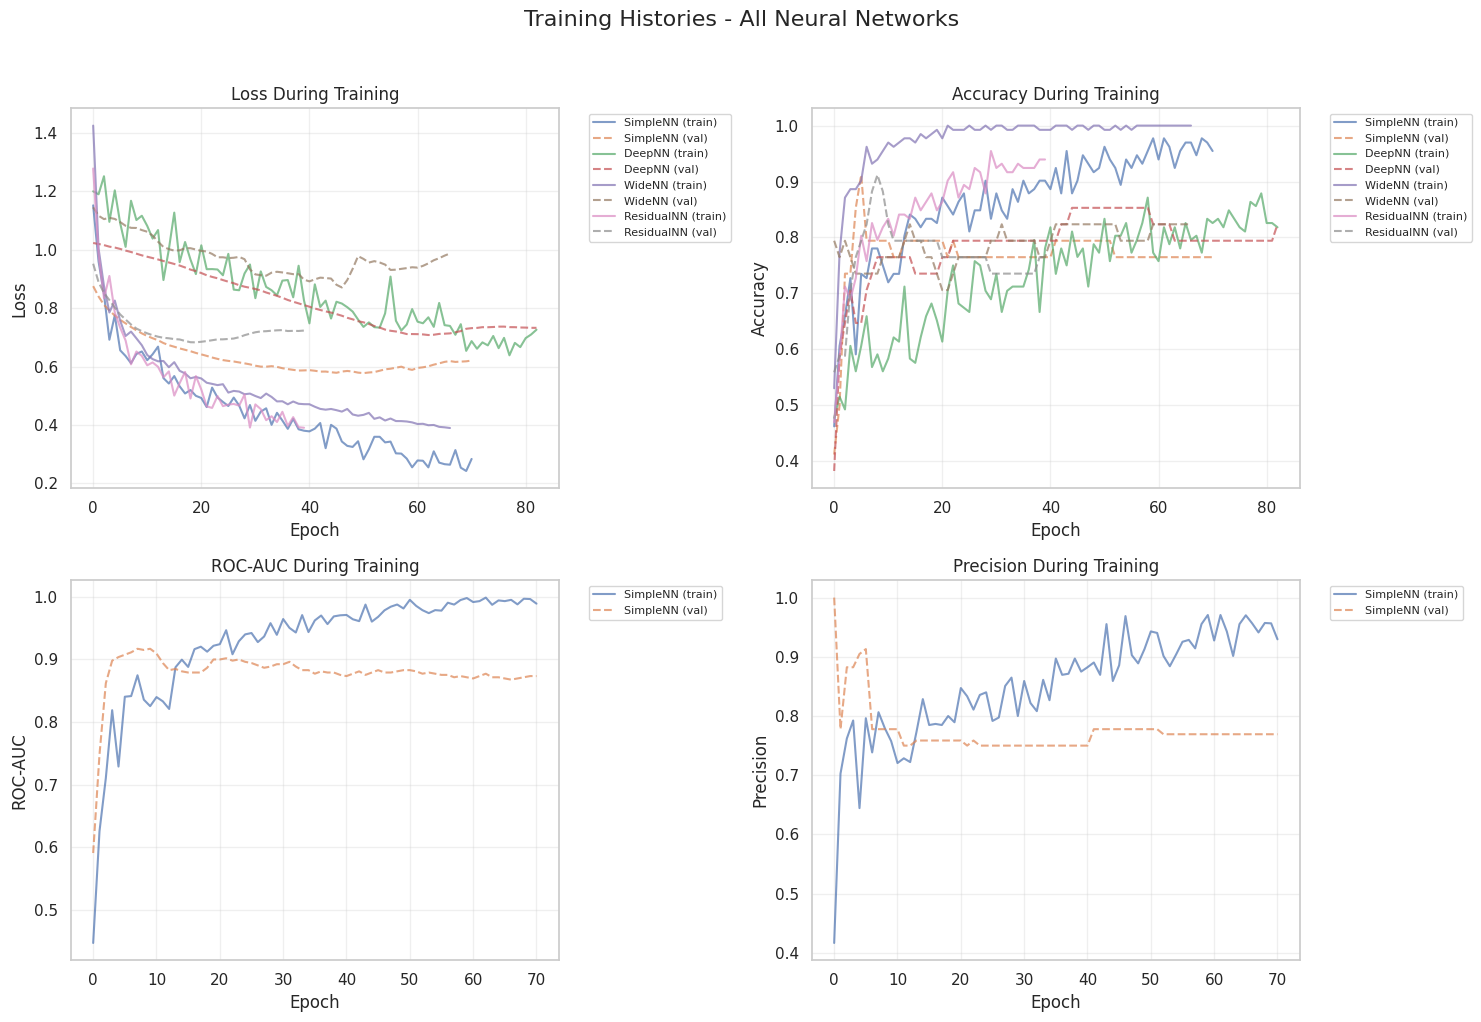


STEP 8: Detailed Evaluation of Best Model
Best model: SimpleNN
Best F1-Score: 0.8085


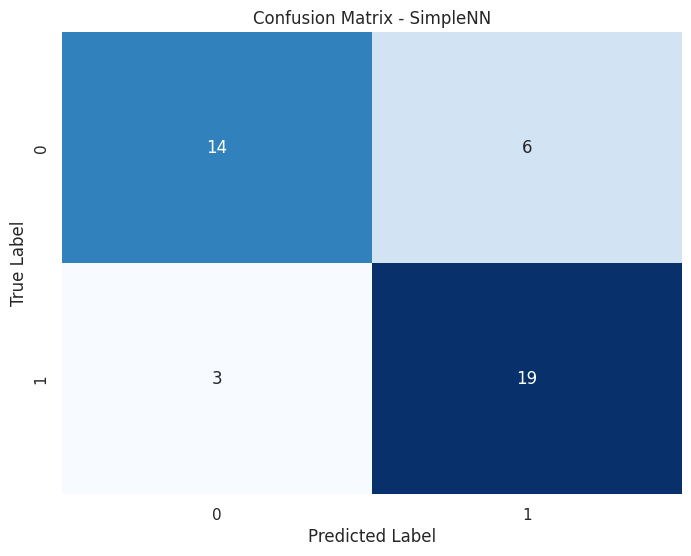


Classification Report:
              precision    recall  f1-score   support

    Rock (R)       0.82      0.70      0.76        20
    Mine (M)       0.76      0.86      0.81        22

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.78        42



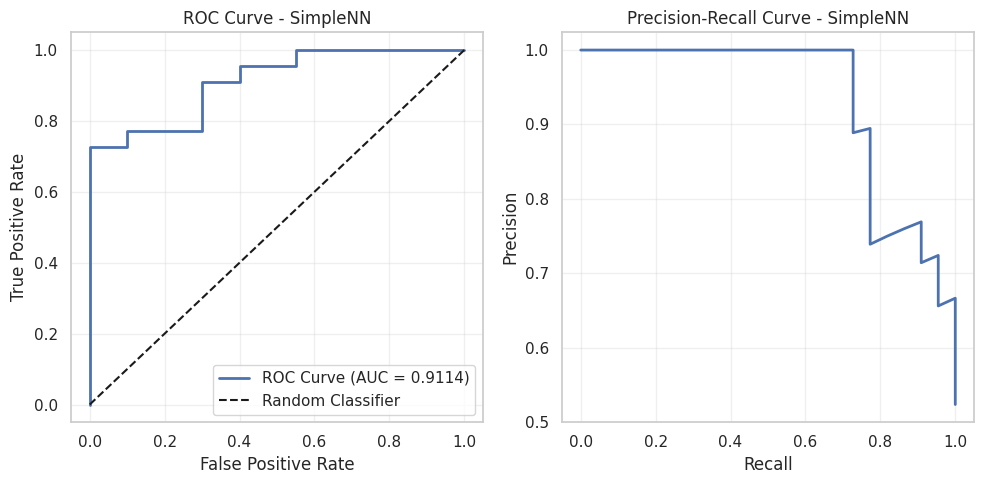


STEP 9: Saving Best Model
✓ Best model (SimpleNN) saved to /content/best_nn_model.h5


✓ All models saved to /content/
✓ Predictions saved to /content/nn_predictions.csv

STEP 10: Computing Feature Importance
Computing permutation importance (this may take a moment)...


,feature,importance
12,Attribute12,0.059773
7,Attribute36,0.051591
5,Attribute44,0.035227
13,Attribute10,0.032955
1,Attribute52,0.027500
14,Attribute8,0.024545
4,Attribute45,0.022727
8,Attribute21,0.022500
9,Attribute1,0.021136
10,Attribute4,0.016364


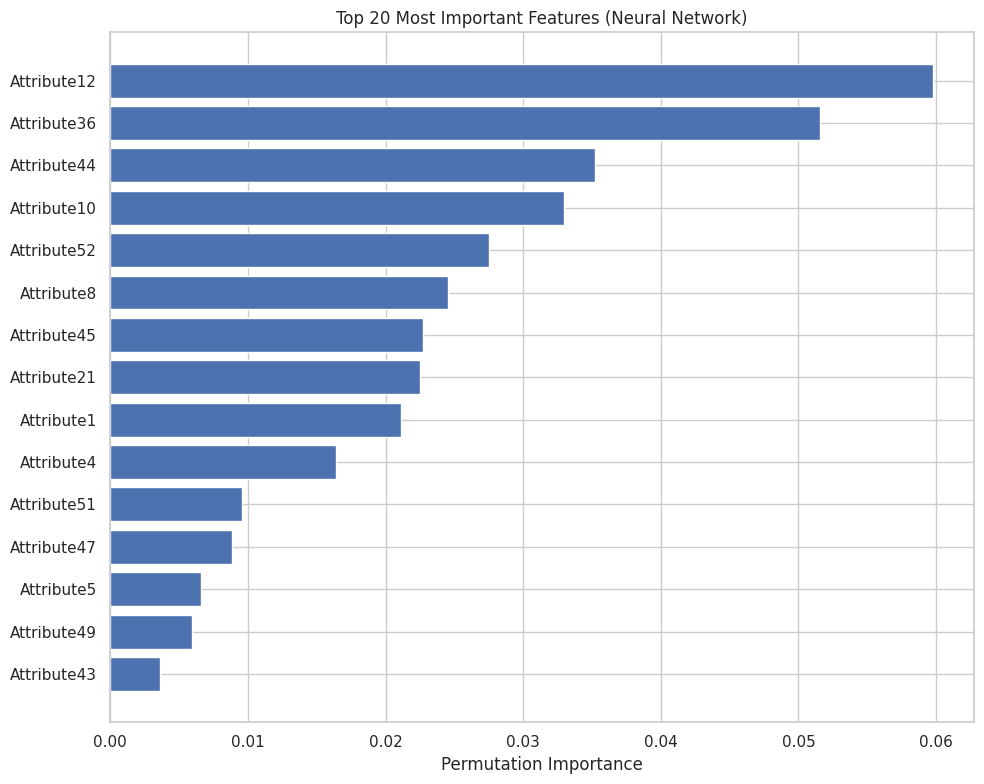


NEURAL NETWORK TRAINING COMPLETE!

Saved files:
  - /content/nn_scaler.pkl
  - /content/nn_results_summary.csv
  - /content/nn_training_history.png
  - /content/nn_confusion_matrix.png
  - /content/nn_roc_pr_curves.png
  - /content/best_nn_model.h5
  - /content/nn_predictions.csv
  - /content/nn_feature_importance.csv
  - /content/nn_feature_importance.png

All models saved as: [ModelName]_final.h5


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ========== 1) Load Data from Existing Variables ==========
print("\n" + "="*60)
print("STEP 1: Loading preprocessed data from notebook variables")
print("="*60)

# Try to load from the best available dataframe
if 'df_final_vif' in globals():
    df_model = df_final_vif.copy()
    print("✓ Loaded df_final_vif (final cleaned dataset after VIF filtering)")
elif 'df_final' in globals():
    df_model = df_final.copy()
    if 'Attribute11' in df_model.columns:
        df_model = df_model.drop(columns=['Attribute11'])
    print("✓ Loaded df_final (after representative selection)")
elif 'df_reduced' in globals():
    df_model = df_reduced.copy()
    print("✓ Loaded df_reduced (after significance testing)")
else:
    raise RuntimeError("No suitable dataset found. Ensure df_final_vif, df_final, or df_reduced exists.")

# Encode categorical labels to numeric (R=0, M=1)
if df_model['class'].dtype not in ['int64', 'int32', 'float64']:
    df_model['label'] = df_model['class'].map({'R': 0, 'M': 1})
else:
    df_model['label'] = df_model['class']

# Prepare features (X) and target (y)
X = df_model.drop(columns=['Unnamed: 0', 'class', 'label'], errors='ignore')
y = df_model['label'].astype(int).values

# Display basic dataset info
print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(pd.Series(y).value_counts(normalize=True))


# ========== 2) Train/Test Split ==========
print("\n" + "="*60)
print("STEP 2: Splitting data (80% train, 20% test)")
print("="*60)

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features for better neural network performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Save scaler for future inference
with open('/content/nn_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved to /content/nn_scaler.pkl")


# ========== 3) Define Neural Network Architectures ==========
print("\n" + "="*60)
print("STEP 3: Defining Neural Network Architectures")
print("="*60)

input_dim = X_train_scaled.shape[1]


# Simple Feedforward Neural Network
def create_simple_nn(input_dim, dropout_rate=0.3, l2_reg=0.001):
    """Simple feedforward neural network"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ], name='SimpleNN')
    return model


# Deep Neural Network
def create_deep_nn(input_dim, dropout_rate=0.4, l2_reg=0.001):
    """Deeper neural network with more layers"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ], name='DeepNN')
    return model


# Wide Neural Network
def create_wide_nn(input_dim, dropout_rate=0.3, l2_reg=0.001):
    """Wide neural network with larger layers"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ], name='WideNN')
    return model


# Residual Neural Network (Skip Connections)
def create_residual_nn(input_dim, dropout_rate=0.3, l2_reg=0.001):
    """Neural network with skip connections (residual)"""
    inputs = Input(shape=(input_dim,))

    # # First dense block
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Second block with residual
    x2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout_rate)(x2)
    x = layers.Add()([x, x2])  # Skip connection

    # Third block
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResidualNN')
    return model

# Create all models
models_dict = {
    'SimpleNN': create_simple_nn(input_dim),
    'DeepNN': create_deep_nn(input_dim),
    'WideNN': create_wide_nn(input_dim),
    'ResidualNN': create_residual_nn(input_dim)
}

print(f"✓ Created {len(models_dict)} neural network architectures")
for name in models_dict.keys():
    print(f"  - {name}")


# ========== 4) Training Configuration ==========
print("\n" + "="*60)
print("STEP 4: Configuring training parameters")
print("="*60)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Training hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001

print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Early stopping patience: 20")
print(f"LR reduction patience: 10")

# ========== 5) Train All Models ==========
print("\n" + "="*60)
print("STEP 5: Training Neural Networks")
print("="*60)

training_histories = {}   # Store training history for each model
trained_models = {}       # Store trained model objects
cv_results = []           # Store test metrics for comparison

# Loop over each model architecture
for model_name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    # Display model architecture
    model.summary()

    # Compile model with Adam optimizer and binary crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    # # Save best model during training based on validation loss
    checkpoint = ModelCheckpoint(
        f'/content/{model_name}_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    # Store results
    training_histories[model_name] = history
    trained_models[model_name] = model

    # Evaluate model on test set
    test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(
        X_test_scaled, y_test, verbose=0
    )

    # Generate predictions for F1-score calculation
    y_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    test_f1 = f1_score(y_test, y_pred)

    print(f"\n{model_name} - Test Set Results:")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall:    {test_rec:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    print(f"  ROC-AUC:   {test_auc:.4f}")

    # Store metrics
    cv_results.append({
        'model': model_name,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'test_roc_auc': test_auc,
        'test_loss': test_loss
    })


# ========== 6) Results Summary ==========
print("\n" + "="*60)
print("STEP 6: Results Summary")
print("="*60)

# Convert metrics to DataFrame and sort by F1-score
results_df = pd.DataFrame(cv_results).sort_values('test_f1', ascending=False)
print("\nNeural Network Performance Summary (sorted by F1-score):")
display(results_df)

# Save results
results_df.to_csv('/content/nn_results_summary.csv', index=False)
print("\n✓ Results saved to /content/nn_results_summary.csv")


# ========== 7) Visualize Training Histories ==========
print("\n" + "="*60)
print("STEP 7: Visualizing Training Histories")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Histories - All Neural Networks', fontsize=16, y=1.02)

metrics = ['loss', 'accuracy', 'auc', 'precision']     # Metrics to plot
titles = ['Loss', 'Accuracy', 'ROC-AUC', 'Precision']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]

    for model_name, history in training_histories.items():
        if metric in history.history:
            ax.plot(history.history[metric], label=f'{model_name} (train)', alpha=0.7)
            ax.plot(history.history[f'val_{metric}'],
                   label=f'{model_name} (val)', linestyle='--', alpha=0.7)

    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.set_title(f'{title} During Training')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


# ========== 8) Best Model Evaluation ==========
print("\n" + "="*60)
print("STEP 8: Detailed Evaluation of Best Model")
print("="*60)

# Select best model based on highest F1-score
best_model_name = results_df.iloc[0]['model']
best_model = trained_models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best F1-Score: {results_df.iloc[0]['test_f1']:.4f}")

# Predictions
y_pred_proba = best_model.predict(X_test_scaled, verbose=0).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rock (R)', 'Mine (M)']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/nn_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()


# ========== 9) Save Best Model ==========
print("\n" + "="*60)
print("STEP 9: Saving Best Model")
print("="*60)

best_model.save('/content/best_nn_model.h5')
print(f"✓ Best model ({best_model_name}) saved to /content/best_nn_model.h5")

# Save all trained models
for model_name, model in trained_models.items():
    model.save(f'/content/{model_name}_final.h5')
print(f"✓ All models saved to /content/")

# Save predictions
predictions_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_pred,
    'predicted_probability': y_pred_proba
})
predictions_df.to_csv('/content/nn_predictions.csv', index=False)
print("✓ Predictions saved to /content/nn_predictions.csv")


# ========== 10) Feature Importance (Permutation) ==========
print("\n" + "="*60)
print("STEP 10: Computing Feature Importance")
print("="*60)

def compute_permutation_importance(model, X, y, n_repeats=10):
    """Compute permutation importance for neural network"""
    baseline_score = roc_auc_score(y, model.predict(X, verbose=0).flatten())
    importances = []

    for i, col in enumerate(X_train.columns):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            X_perm[:, i] = np.random.permutation(X_perm[:, i])
            score = roc_auc_score(y, model.predict(X_perm, verbose=0).flatten())
            scores.append(baseline_score - score)
        importances.append(np.mean(scores))

    return importances

print("Computing permutation importance (this may take a moment)...")
feature_importance = compute_permutation_importance(
    best_model, X_test_scaled, y_test, n_repeats=10
)

# Store feature importance in a DataFrame
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

display(importance_df.head(20))
importance_df.to_csv('/content/nn_feature_importance.csv', index=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 Most Important Features (Neural Network)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/nn_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("NEURAL NETWORK TRAINING COMPLETE!")
print("="*60)
print("\nSaved files:")
print("  - /content/nn_scaler.pkl")
print("  - /content/nn_results_summary.csv")
print("  - /content/nn_training_history.png")
print("  - /content/nn_confusion_matrix.png")
print("  - /content/nn_roc_pr_curves.png")
print("  - /content/best_nn_model.h5")
print("  - /content/nn_predictions.csv")
print("  - /content/nn_feature_importance.csv")
print("  - /content/nn_feature_importance.png")
print("\nAll models saved as: [ModelName]_final.h5")

In [ ]:
!pip install scikeras

# Advanced Hyperparameter Tuning Pipeline for ML & NN Models

 ADVANCED HYPERPARAMETER TUNING - ALL MODELS

STEP 1: Loading Preprocessed Data
✓ Loaded df_final_vif
Dataset shape: (208, 15)
Features: 15, Samples: 208
Class distribution: {1: 0.5336538461538461, 0: 0.46634615384615385}

Train: (166, 15), Test: (42, 15)

STEP 2: Defining Hyperparameter Search Spaces
✓ Hyperparameter grids defined for all models

STEP 3: Training Traditional ML Models with RandomizedSearchCV

Tuning: LogisticRegression
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Best parameters for LogisticRegression:
  clf__solver: saga
  clf__penalty: elasticnet
  clf__max_iter: 2000
  clf__l1_ratio: 0.3
  clf__C: 0.1

LogisticRegression Results:
  Train - Acc: 0.8313, Prec: 0.8348, Rec: 0.8269, F1: 0.8288
  Test  - Acc: 0.7619, Prec: 0.7614, Rec: 0.7614, F1: 0.7614, AUC: 0.8295
  Training time: 7.33s

Tuning: RandomForest
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Best parameters for RandomForest:
  n_estimators: 300
  min_samples_split: 5

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✓ Best parameters for XGBoost:
  subsample: 0.9
  reg_lambda: 1
  reg_alpha: 1
  n_estimators: 300
  min_child_weight: 5
  max_depth: 5
  learning_rate: 0.1
  gamma: 0.1
  colsample_bytree: 0.8

XGBoost Results:
  Train - Acc: 0.9398, Prec: 0.9418, Rec: 0.9377, F1: 0.9392
  Test  - Acc: 0.7857, Prec: 0.7918, Rec: 0.7818, F1: 0.7826, AUC: 0.8795
  Training time: 27.58s

Tuning: LightGBM
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Best parameters for LightGBM:
  subsample: 0.9
  reg_lambda: 0
  reg_alpha: 1
  num_leaves: 50
  n_estimators: 300
  min_child_samples: 30
  max_depth: 5
  learning_rate: 0.05
  colsample_bytree: 0.8

LightGBM Results:
  Train - Acc: 0.9819, Prec: 0.9815, Rec: 0.9823, F1: 0.9818
  Test  - Acc: 0.8095, Prec: 0.8091, Rec: 0.8091, F1: 0.8091, AUC: 0.8909
  Training time: 13.24s

STEP 4: Neural Network Hyperparameter Tuning
Starting Neural Network tuning (this may take several minutes)...

Fitting Neural Network with RandomizedSearchCV...
 Neu

,Model,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Test_AUC_ROC,CV_Best_Score,Training_Time
0,LightGBM,0.981928,0.809524,0.981498,0.809091,0.982271,0.809091,0.981848,0.809091,0.890909,0.822103,13.236292
1,GradientBoosting,1.000000,0.809524,1.000000,0.822115,1.000000,0.804545,1.000000,0.805556,0.897727,0.796892,86.437893
2,XGBoost,0.939759,0.785714,0.941818,0.791765,0.937692,0.781818,0.939194,0.782634,0.879545,0.841303,27.577422
3,RandomForest,0.993976,0.785714,0.994444,0.791765,0.993506,0.781818,0.993939,0.782634,0.872727,0.801526,301.373609
4,SVM,0.969880,0.785714,0.971504,0.823607,0.968408,0.777273,0.969632,0.775401,0.922727,0.811768,1.977935
5,LogisticRegression,0.831325,0.761905,0.834753,0.761364,0.826937,0.761364,0.828841,0.761364,0.829545,0.765611,7.327220



✓ Results saved to /content/hyperparameter_tuning_results.csv

 FORMATTED RESULTS TABLE


,Model,Train_Accuracy,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC_ROC
0,LightGBM,0.9819,0.8095,0.8091,0.8091,0.8091,0.8909
1,GradientBoosting,1.0000,0.8095,0.8221,0.8045,0.8056,0.8977
2,XGBoost,0.9398,0.7857,0.7918,0.7818,0.7826,0.8795
3,RandomForest,0.9940,0.7857,0.7918,0.7818,0.7826,0.8727
4,SVM,0.9699,0.7857,0.8236,0.7773,0.7754,0.9227
5,LogisticRegression,0.8313,0.7619,0.7614,0.7614,0.7614,0.8295



STEP 6: Best Model Detailed Analysis
🏆 BEST MODEL (by Test F1): LightGBM
   Test F1-Score: 0.8091
   Test AUC-ROC: 0.8909

STEP 7: Generating Confusion Matrices for All Tuned Models
Generating confusion matrix for LogisticRegression...
Generating confusion matrix for RandomForest...
Generating confusion matrix for SVM...
Generating confusion matrix for GradientBoosting...
Generating confusion matrix for XGBoost...
Generating confusion matrix for LightGBM...


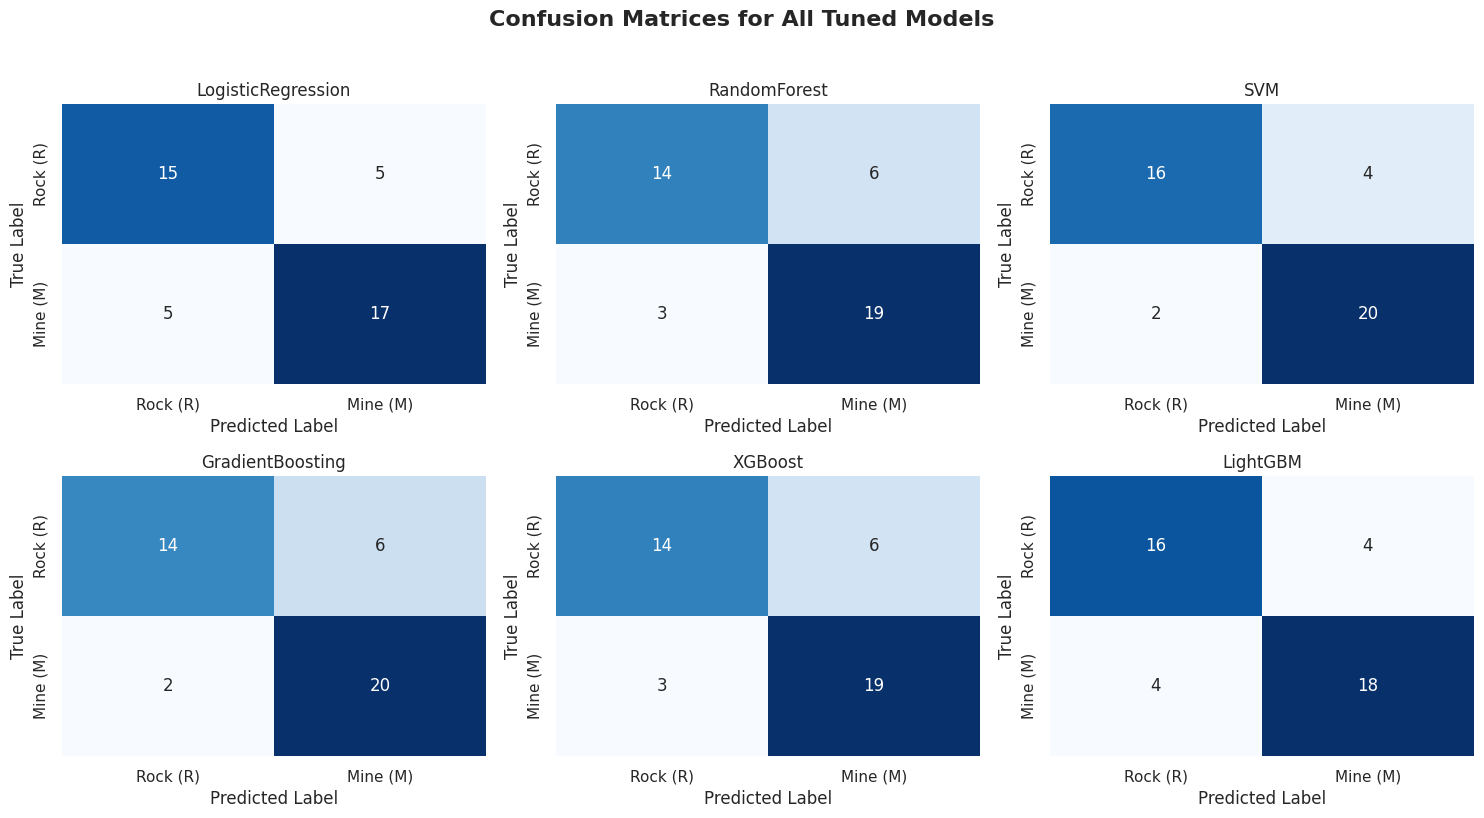


STEP 8: ROC and Precision-Recall Curves (Best Model)


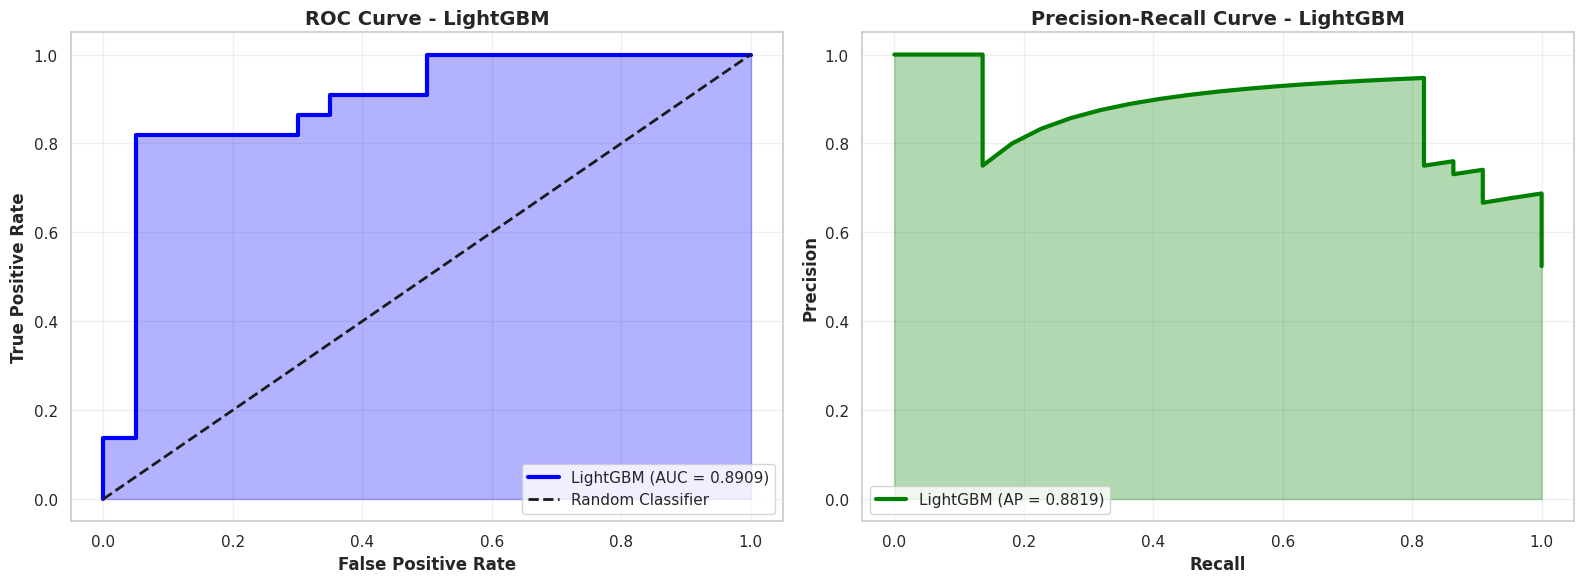


STEP 9: Classification Report (Best Model)

Classification Report - LightGBM:
              precision    recall  f1-score   support

    Rock (R)     0.8000    0.8000    0.8000        20
    Mine (M)     0.8182    0.8182    0.8182        22

    accuracy                         0.8095        42
   macro avg     0.8091    0.8091    0.8091        42
weighted avg     0.8095    0.8095    0.8095        42


STEP 10: Model Performance Comparison Visualization


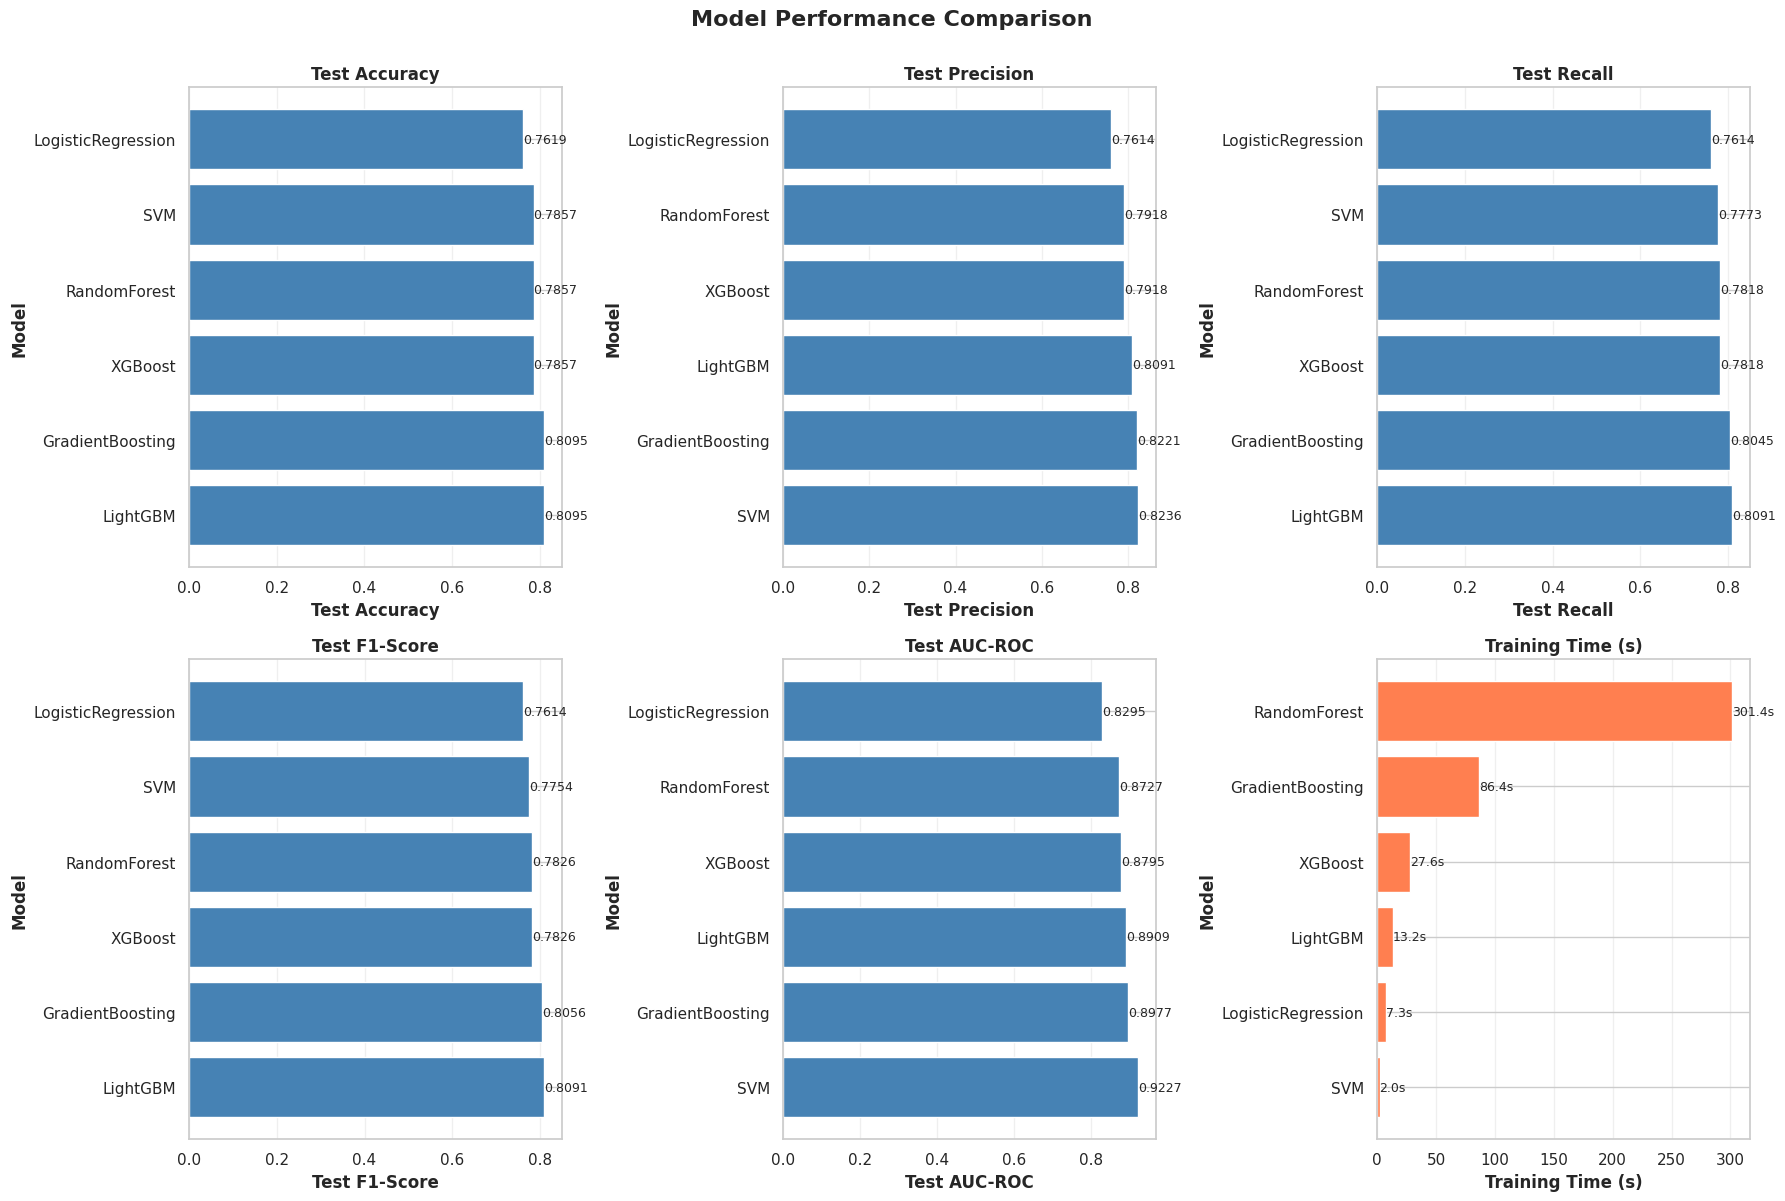


STEP 11: Saving All Tuned Models
✓ Saved LogisticRegression to /content/tuned_LogisticRegression.pkl
✓ Saved RandomForest to /content/tuned_RandomForest.pkl
✓ Saved SVM to /content/tuned_SVM.pkl
✓ Saved GradientBoosting to /content/tuned_GradientBoosting.pkl
✓ Saved XGBoost to /content/tuned_XGBoost.pkl
✓ Saved LightGBM to /content/tuned_LightGBM.pkl
✓ Saved scaler to /content/tuned_scaler.pkl

STEP 12: Feature Importance Analysis
Extracting feature importance from LightGBM...

Top 20 Most Important Features:


,Feature,Importance,Std
7,Attribute36,115,0
4,Attribute45,112,0
13,Attribute10,105,0
10,Attribute4,90,0
12,Attribute12,73,0
1,Attribute52,70,0
8,Attribute21,69,0
0,Attribute51,60,0
6,Attribute43,52,0
11,Attribute5,32,0


✓ Feature importance saved to /content/best_model_feature_importance.csv


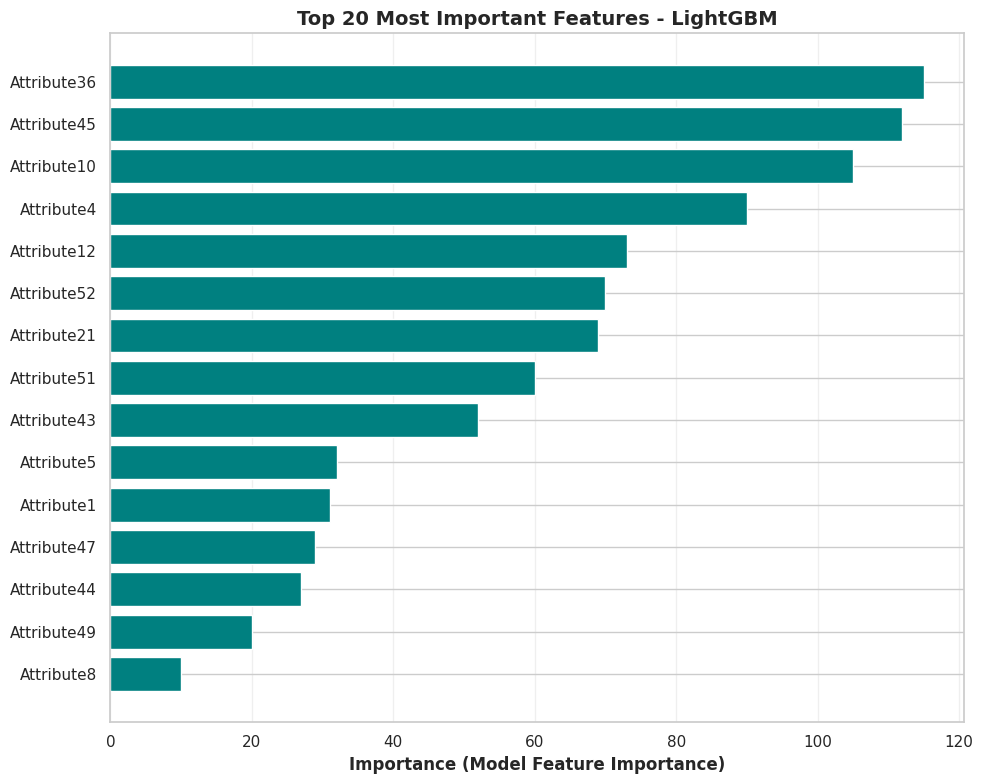


STEP 13: Creating Comprehensive Summary Report

HYPERPARAMETER TUNING - COMPREHENSIVE SUMMARY REPORT

Dataset Information:
-------------------
- Total Samples: 208
- Number of Features: 15
- Training Samples: 166
- Test Samples: 42
- Class Distribution: {1: 0.5336538461538461, 0: 0.46634615384615385}

Best Model: LightGBM

Performance Metrics:
-------------------
Train Accuracy:  0.9819
Test Accuracy:   0.8095
Train Precision: 0.9815
Test Precision:  0.8091
Train Recall:    0.9823
Test Recall:     0.8091
Train F1-Score:  0.9818
Test F1-Score:   0.8091
Test AUC-ROC:    0.8909

Confusion Matrix:
----------------
True Negatives (TN):  16
False Positives (FP): 4
False Negatives (FN): 4
True Positives (TP):  18

Derived Metrics:
---------------
Derived Metrics:
---------------
Sensitivity (TPR): 0.8182
Specificity (TNR): 0.8000
False Positive Rate: 0.2000
False Negative Rate: 0.1818




All Models Ranking (by Test F1-Score):

1. LightGBM
   - Test Accuracy:  0.8095
   - Test Precision: 0.8

,Model,Train_Accuracy,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC_ROC
0,LightGBM,0.9819,0.8095,0.8091,0.8091,0.8091,0.8909
1,GradientBoosting,1.0000,0.8095,0.8221,0.8045,0.8056,0.8977
2,XGBoost,0.9398,0.7857,0.7918,0.7818,0.7826,0.8795
3,RandomForest,0.9940,0.7857,0.7918,0.7818,0.7826,0.8727
4,SVM,0.9699,0.7857,0.8236,0.7773,0.7754,0.9227
5,LogisticRegression,0.8313,0.7619,0.7614,0.7614,0.7614,0.8295



✓ Final results table saved to /content/final_results_table.html

STEP 15: Generating Learning Curves for Best Model
Computing learning curves for LightGBM...


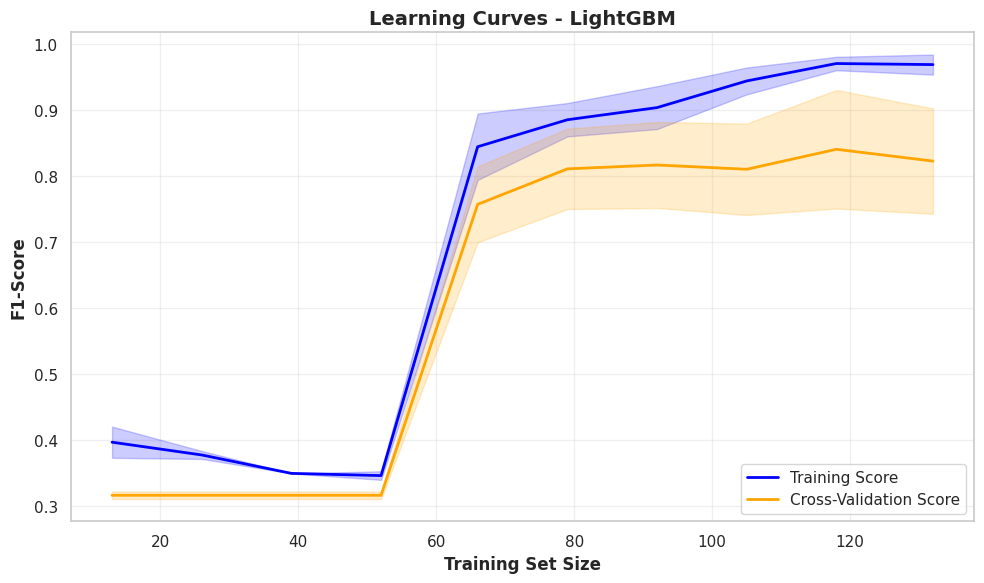


 HYPERPARAMETER TUNING COMPLETED SUCCESSFULLY!

🏆 Best Model: LightGBM
   Test F1-Score: 0.8091
   Test AUC-ROC:  0.8909
   Test Accuracy: 0.8095

📊 Generated Files:
   1. hyperparameter_tuning_results.csv
   2. best_model_confusion_matrix.png
   3. best_model_roc_pr_curves.png
   4. model_comparison.png
   5. best_model_feature_importance.csv
   6. feature_importance_top20.png
   7. tuning_summary_report.txt
   8. final_results_table.html
   9. learning_curves.png
  10. All tuned models (.pkl or .h5)
  11. tuned_scaler.pkl



In [21]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Sklearn imports
from sklearn.model_selection import (StratifiedKFold, GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            accuracy_score, precision_score, recall_score, f1_score,
                            roc_curve, make_scorer)
# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # REMOVED
from scikeras.wrappers import KerasClassifier # Replaced with scikeras


# Optional imports
try:
    from xgboost import XGBClassifier
    has_xgb = True
except:
    has_xgb = False
    print(" XGBoost not available")

try:
    import lightgbm as lgb
    has_lgb = True
except:
    has_lgb = False
    print(" LightGBM not available")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print(" ADVANCED HYPERPARAMETER TUNING - ALL MODELS")
print("="*80)

# ========== 1) LOAD DATA ==========
print("\n" + "="*80)
print("STEP 1: Loading Preprocessed Data")
print("="*80)

# Load the first available preprocessed dataset
if 'df_final_vif' in globals():
    df_model = df_final_vif.copy()
    print("✓ Loaded df_final_vif")
elif 'df_final' in globals():
    df_model = df_final.copy()
    if 'Attribute11' in df_model.columns:
        df_model = df_model.drop(columns=['Attribute11'])
    print("✓ Loaded df_final")
elif 'df_reduced' in globals():
    df_model = df_reduced.copy()
    print("✓ Loaded df_reduced")
else:
    raise RuntimeError("No dataset found! Ensure df_final_vif, df_final, or df_reduced exists.")

# Encode labels to 0/1 if not numeric
if df_model['class'].dtype not in ['int64', 'int32', 'float64']:
    df_model['label'] = df_model['class'].map({'R': 0, 'M': 1})
else:
    df_model['label'] = df_model['class']

# Separate features and target
X = df_model.drop(columns=['Unnamed: 0', 'class', 'label'], errors='ignore')
y = df_model['label'].astype(int).values

print(f"Dataset shape: {X.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"Class distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}")

# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")


# ========== 2) HYPERPARAMETER GRIDS ==========
print("\n" + "="*80)
print("STEP 2: Defining Hyperparameter Search Spaces")
print("="*80)

# Logistic Regression hyperparameters
lr_param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__solver': ['saga'],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'clf__max_iter': [2000]
}

# Random Forest hyperparameters
rf_param_grid = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# SVM hyperparameters
svm_param_grid = {
    'clf__C': [0.1, 1, 10, 50, 100],
    'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'clf__kernel': ['rbf', 'poly'],
    'clf__degree': [2, 3],  # Only for poly
    'clf__class_weight': ['balanced', None]
}

# Gradient Boosting hyperparameters
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# XGBoost hyperparameters
if has_xgb:
    xgb_param_grid = {
        'n_estimators': [200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 10, 100]
    }

# LightGBM hyperparameters
if has_lgb:
    lgb_param_grid = {
        'n_estimators': [200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 50],
        'max_depth': [5, 10, 15, -1],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    }

print("✓ Hyperparameter grids defined for all models")


# ========== 3) TRAIN TRADITIONAL ML MODELS WITH HYPERPARAMETER TUNING ==========
print("\n" + "="*80)
print("STEP 3: Training Traditional ML Models with RandomizedSearchCV")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'f1_macro'

tuned_models = {}     # Store best models
tuning_results = []   # Store results for comparison

# Helper function to train and evaluate a model
def train_and_evaluate(name, model, param_grid, n_iter=50):
    print(f"\n{'='*80}")
    print(f"Tuning: {name}")
    print(f"{'='*80}")

    start_time = time()

    # RandomizedSearchCV to find best hyperparameters
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)

    elapsed_time = time() - start_time

    print(f"\n✓ Best parameters for {name}:")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")

    # Evaluate on train and test
    best_model = search.best_estimator_

    # Train predictions
    y_train_pred = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred, average='macro')
    train_rec = recall_score(y_train, y_train_pred, average='macro')
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    # Test predictions
    y_test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, average='macro')
    test_rec = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    # ROC-AUC
    try:
        if hasattr(best_model, "predict_proba"):
            y_test_proba = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model, "decision_function"):
            y_test_proba = best_model.decision_function(X_test)
        test_auc = roc_auc_score(y_test, y_test_proba)
    except:
        test_auc = np.nan

    print(f"\n{name} Results:")
    print(f"  Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"  Test  - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")
    print(f"  Training time: {elapsed_time:.2f}s")

    tuned_models[name] = best_model

    tuning_results.append({
        'Model': name,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Train_Precision': train_prec,
        'Test_Precision': test_prec,
        'Train_Recall': train_rec,
        'Test_Recall': test_rec,
        'Train_F1': train_f1,
        'Test_F1': test_f1,
        'Test_AUC_ROC': test_auc,
        'CV_Best_Score': search.best_score_,
        'Training_Time': elapsed_time
    })

    return best_model

# Train Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])
train_and_evaluate('LogisticRegression', lr_pipeline, lr_param_grid, n_iter=30)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
train_and_evaluate('RandomForest', rf_model, rf_param_grid, n_iter=50)

# Train SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state=42))
])
train_and_evaluate('SVM', svm_pipeline, svm_param_grid, n_iter=30)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
train_and_evaluate('GradientBoosting', gb_model, gb_param_grid, n_iter=40)

# Train XGBoost
if has_xgb:
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    train_and_evaluate('XGBoost', xgb_model, xgb_param_grid, n_iter=50)

# Train LightGBM
if has_lgb:
    lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    train_and_evaluate('LightGBM', lgb_model, lgb_param_grid, n_iter=50)


# ========== 4) NEURAL NETWORK HYPERPARAMETER TUNING ==========
print("\n" + "="*80)
print("STEP 4: Neural Network Hyperparameter Tuning")
print("="*80)

# Scale data for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

# Define NN builder function
def create_nn_model(neurons_layer1=128, neurons_layer2=64, neurons_layer3=32,
                    dropout_rate=0.3, l2_reg=0.001, learning_rate=0.001,
                    activation='relu'):
    from tensorflow.keras import regularizers

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_layer1, activation=activation,
              kernel_regularizer=regularizers.l2(l2_reg)),    # L2 regularization
        BatchNormalization(),   # Normalize activations for stability
        Dropout(dropout_rate),  # Reduce overfitting
        Dense(neurons_layer2, activation=activation,
              kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(neurons_layer3, activation=activation,
              kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')    # Output layer for binary classification
    ])

  # Compile model with Adam optimizer and binary crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define parameter grid for RandomizedSearchCV
nn_param_grid = {
    'model__neurons_layer1': [64, 128, 256],
    'model__neurons_layer2': [32, 64, 128],
    'model__neurons_layer3': [16, 32, 64],
    'model__dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'model__l2_reg': [0.0001, 0.001, 0.01],
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'model__activation': ['relu', 'elu'],
    'batch_size': [16, 32, 64],
    'epochs': [100]  # Will use early stopping
}

print("Starting Neural Network tuning (this may take several minutes)...")

# Define callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=0)

# Wrap model for sklearn compatibility
try:
    # from scikeras.wrappers import KerasClassifier

    nn_model = KerasClassifier(
        model=create_nn_model, # Explicitly pass the builder function
        verbose=0,
        callbacks=[early_stop, reduce_lr],
        validation_split=0.2
    )

   # Perform randomized hyperparameter search
    nn_search = RandomizedSearchCV(
        estimator=nn_model,
        param_distributions=nn_param_grid,
        n_iter=20,  # Reduced for time efficiency
        cv=3,  # 3-fold for speed
        scoring='f1_macro',
        n_jobs=1,  # Neural networks use internal parallelization
        verbose=2,
        random_state=42
    )

    print("\nFitting Neural Network with RandomizedSearchCV...")
    nn_search.fit(X_train_scaled, y_train)

    # Print best hyperparameters
    print(f"\n✓ Best parameters for Neural Network:")
    for param, value in nn_search.best_params_.items():
        print(f"  {param}: {value}")

    best_nn = nn_search.best_estimator_

    # Train predictions
    y_train_pred_nn = (best_nn.predict(X_train_scaled) > 0.5).astype(int).flatten()
    train_acc_nn = accuracy_score(y_train, y_train_pred_nn)
    train_prec_nn = precision_score(y_train, y_train_pred_nn, average='macro')
    train_rec_nn = recall_score(y_train, y_train_pred_nn, average='macro')
    train_f1_nn = f1_score(y_train, y_train_pred_nn, average='macro')

    # Test predictions
    y_test_pred_nn = (best_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_test_proba_nn = best_nn.predict(X_test_scaled).flatten()

    test_acc_nn = accuracy_score(y_test, y_test_pred_nn)
    test_prec_nn = precision_score(y_test, y_test_pred_nn, average='macro')
    test_rec_nn = recall_score(y_test, y_test_pred_nn, average='macro')
    test_f1_nn = f1_score(y_test, y_test_pred_nn, average='macro')
    test_auc_nn = roc_auc_score(y_test, y_test_proba_nn)

    # Display results
    print(f"\nNeural Network Results:")
    print(f"  Train - Acc: {train_acc_nn:.4f}, Prec: {train_prec_nn:.4f}, Rec: {train_rec_nn:.4f}, F1: {train_f1_nn:.4f}")
    print(f"  Test  - Acc: {test_acc_nn:.4f}, Prec: {test_prec_nn:.4f}, Rec: {test_rec_nn:.4f}, F1: {test_f1_nn:.4f}, AUC: {test_auc_nn:.4f}")

    # Save best NN model in tuned_models dict
    tuned_models['NeuralNetwork'] = best_nn

    # Append results for later summary
    tuning_results.append({
        'Model': 'NeuralNetwork',
        'Train_Accuracy': train_acc_nn,
        'Test_Accuracy': test_acc_nn,
        'Train_Precision': train_prec_nn,
        'Test_Precision': test_prec_nn,
        'Train_Recall': train_rec_nn,
        'Test_Recall': test_rec_nn,
        'Train_F1': train_f1_nn,
        'Test_F1': test_f1_nn,
        'Test_AUC_ROC': test_auc_nn,
        'CV_Best_Score': nn_search.best_score_,
        'Training_Time': 0  # Not tracked for NN
    })

except Exception as e:
    print(f" Neural network tuning failed: {e}")
    print("Continuing with traditional ML models only...")

# ========== 5) RESULTS SUMMARY TABLE ==========
print("\n" + "="*80)
print("STEP 5: Complete Results Summary")
print("="*80)

# Create a DataFrame from all model tuning results
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values('Test_F1', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print(" HYPERPARAMETER TUNING RESULTS - ALL MODELS")
print("="*80)
display(results_df)

# Save results to CSV for reference
results_df.to_csv('/content/hyperparameter_tuning_results.csv', index=False)
print("\n✓ Results saved to /content/hyperparameter_tuning_results.csv")

# Create formatted display table
print("\n" + "="*80)
print(" FORMATTED RESULTS TABLE")
print("="*80)

formatted_results = results_df[['Model', 'Train_Accuracy', 'Test_Accuracy',
                                'Test_Precision', 'Test_Recall', 'Test_F1',
                                'Test_AUC_ROC']].copy()

# Round all metrics to 4 decimals for display
for col in formatted_results.columns[1:]:
    formatted_results[col] = formatted_results[col].apply(lambda x: f"{x:.4f}")

display(formatted_results)


# ========== 6) BEST MODEL ANALYSIS ==========
print("\n" + "="*80)
print("STEP 6: Best Model Detailed Analysis")
print("="*80)

# Determine the best model based on Test F1 score
best_model_name = results_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]

print(f"🏆 BEST MODEL (by Test F1): {best_model_name}")
print(f"   Test F1-Score: {results_df.iloc[0]['Test_F1']:.4f}")
print(f"   Test AUC-ROC: {results_df.iloc[0]['Test_AUC_ROC']:.4f}")

# Get predictions for the overall best model
if best_model_name == 'NeuralNetwork':
    # Neural Network outputs probabilities; threshold at 0.5 for binary predictions
    y_test_pred_best = (best_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_test_proba_best = best_model.predict(X_test_scaled).flatten()
else:
    # For tree-based or sklearn models
    y_test_pred_best = best_model.predict(X_test)
    if hasattr(best_model, 'predict_proba'):
        y_test_proba_best = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, 'decision_function'):
        y_test_proba_best = best_model.decision_function(X_test)
    else:
        y_test_proba_best = None # Fallback if no probability/decision function


# ========== 7) CONFUSION MATRIX FOR ALL MODELS ==========
print("\n" + "="*80)
print("STEP 7: Generating Confusion Matrices for All Tuned Models")
print("="*80)

# Determine the number of models to plot
n_models = len(tuned_models)

# Calculate grid size (e.g., 2 rows, ceil(n_models/2) columns)
n_cols = 3 # Customize number of columns
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

# Remove unused subplots if any
for i in range(n_models, len(axes)):
    fig.delaxes(axes[i])

# Generate and plot confusion matrix for each tuned model
for i, (name, model) in enumerate(tuned_models.items()):
    print(f"Generating confusion matrix for {name}...")

    # Prepare data for prediction
    if name == 'NeuralNetwork':
        X_test_eval = X_test_scaled
        y_test_eval = y_test
    else:
        X_test_eval = X_test
        y_test_eval = y_test

    # Get binary predictions
    if hasattr(model, 'predict'):
        y_pred = model.predict(X_test_eval)
        # For models that output probabilities (like NN), convert to binary
        if name == 'NeuralNetwork':
             y_pred = (y_pred > 0.5).astype(int).flatten()
        elif hasattr(model, 'predict_proba'):
             y_pred = (model.predict_proba(X_test_eval)[:, 1] > 0.5).astype(int)
        elif hasattr(model, 'decision_function'):
             y_pred = (model.decision_function(X_test_eval) > 0).astype(int)

    elif hasattr(model, 'predict_classes'): # For older Keras versions if applicable
         y_pred = model.predict_classes(X_test_eval)
    else:
         print(f"Warning: Could not get predictions for {name}. Skipping confusion matrix.")
         continue

    cm = confusion_matrix(y_test_eval, y_pred)

    # Plot confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Rock (R)', 'Mine (M)'],
                yticklabels=['Rock (R)', 'Mine (M)'],
                ax=axes[i], annot_kws={'size': 12})
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.suptitle('Confusion Matrices for All Tuned Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/all_models_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


# ========== 8) ROC & PR CURVES (FOR BEST MODEL ONLY - can extend to all) ==========
print("\n" + "="*80)
print("STEP 8: ROC and Precision-Recall Curves (Best Model)")
print("="*80)

# Using the best model predictions from STEP 6
if best_model_name == 'NeuralNetwork':
    y_test_eval_best = y_test # Use original y_test for metrics
    y_test_pred_best_binary = y_test_pred_best # Binary predictions
    y_test_proba_best_eval = y_test_proba_best # Probabilities
else:
    y_test_eval_best = y_test
    y_test_pred_best_binary = y_test_pred_best
    y_test_proba_best_eval = y_test_proba_best


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
if y_test_proba_best_eval is not None and len(np.unique(y_test_eval_best)) > 1:
    try:
        fpr, tpr, thresholds = roc_curve(y_test_eval_best, y_test_proba_best_eval)
        roc_auc = roc_auc_score(y_test_eval_best, y_test_proba_best_eval)

        axes[0].plot(fpr, tpr, linewidth=3, label=f'{best_model_name} (AUC = {roc_auc:.4f})', color='blue')
        axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
        axes[0].fill_between(fpr, tpr, alpha=0.3, color='blue')
        axes[0].set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
        axes[0].set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
        axes[0].set_title(f'ROC Curve - {best_model_name}', fontweight='bold', fontsize=14)
        axes[0].legend(loc='lower right', fontsize=11)
        axes[0].grid(True, alpha=0.3)
    except Exception as e:
         axes[0].set_title(f'ROC Curve - {best_model_name}\n(Error generating: {e})', fontweight='bold', fontsize=14)
         axes[0].text(0.5, 0.5, 'Error generating ROC Curve', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

else:
    axes[0].set_title(f'ROC Curve - {best_model_name}\n(Not applicable)', fontweight='bold', fontsize=14)
    axes[0].text(0.5, 0.5, 'Data not suitable for ROC Curve', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)


# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

if y_test_proba_best_eval is not None and len(np.unique(y_test_eval_best)) > 1:
    try:
        precision, recall, _ = precision_recall_curve(y_test_eval_best, y_test_proba_best_eval)
        avg_precision = average_precision_score(y_test_eval_best, y_test_proba_best_eval)

        axes[1].plot(recall, precision, linewidth=3,
                    label=f'{best_model_name} (AP = {avg_precision:.4f})', color='green')
        axes[1].fill_between(recall, precision, alpha=0.3, color='green')
        axes[1].set_xlabel('Recall', fontweight='bold', fontsize=12)
        axes[1].set_ylabel('Precision', fontweight='bold', fontsize=12)
        axes[1].set_title(f'Precision-Recall Curve - {best_model_name}', fontweight='bold', fontsize=14)
        axes[1].legend(loc='lower left', fontsize=11)
        axes[1].grid(True, alpha=0.3)
    except Exception as e:
         axes[1].set_title(f'Precision-Recall Curve - {best_model_name}\n(Error generating: {e})', fontweight='bold', fontsize=14)
         axes[1].text(0.5, 0.5, 'Error generating PR Curve', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

else:
    axes[1].set_title(f'Precision-Recall Curve - {best_model_name}\n(Not applicable)', fontweight='bold', fontsize=14)
    axes[1].text(0.5, 0.5, 'Data not suitable for PR Curve', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)


plt.tight_layout()
plt.savefig('/content/best_model_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()


# ========== 9) CLASSIFICATION REPORT (FOR BEST MODEL ONLY - can extend to all) ==========
print("\n" + "="*80)
print("STEP 9: Classification Report (Best Model)")
print("="*80)

# Using the best model binary predictions from STEP 6
if len(np.unique(y_test_eval_best)) > 1:
    print(f"\nClassification Report - {best_model_name}:")
    print(classification_report(y_test_eval_best, y_test_pred_best_binary,
                            target_names=['Rock (R)', 'Mine (M)'],
                            digits=4))
else:
    print(f"\nClassification Report - {best_model_name}: Not applicable for single class.")


# ========== 10) MODEL COMPARISON VISUALIZATION ==========
print("\n" + "="*80)
print("STEP 10: Model Performance Comparison Visualization")
print("="*80)

# Horizontal bar plots for key metrics across all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall',
           'Test_F1', 'Test_AUC_ROC', 'Training_Time']
titles = ['Test Accuracy', 'Test Precision', 'Test Recall',
          'Test F1-Score', 'Test AUC-ROC', 'Training Time (s)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 3, idx % 3]

    # Handle cases where a metric might not be available for a model (e.g., Training_Time for NN)
    data = results_df.copy()
    # Sort for better visualization
    if metric != 'Training_Time': # Don't sort NN's 0 training time first
        data = data.sort_values(metric, ascending=False)
    else:
         data = data.sort_values(metric, ascending=True)

    if metric == 'Training_Time':
        # Handle NaN for NN's training time gracefully in plot
        data[metric] = data[metric].replace(0, np.nan)
        bars = ax.barh(data['Model'], data[metric], color='coral')
        ax.set_xlabel(title, fontweight='bold')
        # Add value labels, skipping NaN
        for i, bar in enumerate(bars):
            width = bar.get_width()
            if not np.isnan(width):
                 ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.1f}s', ha='left', va='center', fontsize=9)
    else:
        bars = ax.barh(data['Model'], data[metric], color='steelblue')
        ax.set_xlabel(title, fontweight='bold')
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.4f}', ha='left', va='center', fontsize=9)


    ax.set_ylabel('Model', fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='x', alpha=0.3)


plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 11) SAVE ALL MODELS ==========
print("\n" + "="*80)
print("STEP 11: Saving All Tuned Models")
print("="*80)

for model_name, model in tuned_models.items():
    if model_name == 'NeuralNetwork':
        # Save Keras Neural Network model to .h5 file
        try:
            model.model_.save(f'/content/tuned_{model_name}.h5')
            print(f"✓ Saved {model_name} to /content/tuned_{model_name}.h5")
        except Exception as e:
            print(f" Could not save {model_name}: {e}")
    else:
        # Save sklearn-based models to .pkl using pickle
        try:
            with open(f'/content/tuned_{model_name}.pkl', 'wb') as f:
                pickle.dump(model, f)
            print(f"✓ Saved {model_name} to /content/tuned_{model_name}.pkl")
        except Exception as e:
            print(f" Could not save {model_name}: {e}")


# Save scaler (only relevant if using scaler outside pipeline)
# In this setup, scaler is part of pipelines or used explicitly for NN,
# saving it separately might not be strictly necessary depending on next steps,
# but it's good practice if you might need to scale new data later.
try:
    if 'scaler' in globals():
         with open('/content/tuned_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
         print("✓ Saved scaler to /content/tuned_scaler.pkl")
    else:
        print("⚠️ Scaler object not found in global scope. Skipping scaler save.")
except Exception as e:
     print(f"⚠️ Could not save scaler: {e}")


# ========== 12) FEATURE IMPORTANCE FOR BEST MODEL ==========
print("\n" + "="*80)
print("STEP 12: Feature Importance Analysis")
print("="*80)

if best_model_name == 'NeuralNetwork':
  # Neural Networks don't have built-in feature importance; use permutation importance
    print("Computing permutation importance for Neural Network...")
    from sklearn.inspection import permutation_importance

    # Permutation importance requires a scorer function or string
    # Using 'f1_macro' as the scoring metric
    scorer = make_scorer(f1_score, average='macro')

    # Permutation importance needs original X_test for models within pipelines
    # and scaled X_test for NeuralNetwork.
    if 'scaler' in globals():
         X_test_importance = X_test_scaled # Use scaled for NN
    else:
         X_test_importance = X_test # Use original for others (pipelines handle scaling)

    # Need to wrap the KerasClassifier predict method for permutation importance if needed
    # However, permutation_importance can often handle estimators directly if they have predict_proba or predict

    try:
        perm_importance = permutation_importance(
            best_model, X_test_importance, y_test, # Use y_test (numpy) for metrics
            n_repeats=10, random_state=42, scoring=scorer, n_jobs=-1
        )

        # Get feature names from the original X DataFrame
        feature_names = X.columns

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        print("\nTop 20 Most Important Features:")
        display(importance_df.head(20))

        importance_df.to_csv('/content/best_model_feature_importance.csv', index=False)
        print("✓ Feature importance saved to /content/best_model_feature_importance.csv")

        # Visualize top 20 features
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['Importance'], color='teal')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance (F1-macro permutation importance)', fontweight='bold', fontsize=12)
        plt.title(f'Top 20 Most Important Features - {best_model_name}',
                fontweight='bold', fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('/content/feature_importance_top20.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not compute permutation importance for Neural Network: {e}")
        importance_df = pd.DataFrame() # Create empty df if failed

# Tree-based models (RandomForest, XGBoost, LightGBM) have built-in feature importance
elif best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']:
    print(f"Extracting feature importance from {best_model_name}...")

    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = X.columns # Use original X column names

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances,
            'Std': 0 # Tree-based models don't provide std directly
        }).sort_values('Importance', ascending=False)

        print("\nTop 20 Most Important Features:")
        display(importance_df.head(20))

        importance_df.to_csv('/content/best_model_feature_importance.csv', index=False)
        print("✓ Feature importance saved to /content/best_model_feature_importance.csv")

        # Visualize top 20 features
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['Importance'], color='teal')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance (Model Feature Importance)', fontweight='bold', fontsize=12)
        plt.title(f'Top 20 Most Important Features - {best_model_name}',
                fontweight='bold', fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('/content/feature_importance_top20.png', dpi=300, bbox_inches='tight')
        plt.show()

    else:
        print(f"⚠️ Model {best_model_name} does not have a 'feature_importances_' attribute.")
        importance_df = pd.DataFrame() # Create empty df if not applicable


else:
    print(f"Computing permutation importance for {best_model_name}...")
    from sklearn.inspection import permutation_importance

    # Permutation importance requires a scorer function or string
    scorer = make_scorer(f1_score, average='macro')

    # Permutation importance needs original X_test for models within pipelines
    # and scaled X_test for NeuralNetwork.
    # For models like LR and SVM within pipelines, use the original X_test
    X_test_importance = X_test

    try:
        perm_importance = permutation_importance(
            best_model, X_test_importance, y_test, # Use y_test (numpy) for metrics
            n_repeats=10, random_state=42, scoring=scorer, n_jobs=-1
        )

        # Get feature names from the original X DataFrame
        feature_names = X.columns

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        print("\nTop 20 Most Important Features:")
        display(importance_df.head(20))

        importance_df.to_csv('/content/best_model_feature_importance.csv', index=False)
        print("✓ Feature importance saved to /content/best_model_feature_importance.csv")

        # Visualize top 20 features
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['Importance'], color='teal')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance (F1-macro permutation importance)', fontweight='bold', fontsize=12)
        plt.title(f'Top 20 Most Important Features - {best_model_name}',
                fontweight='bold', fontsize=14)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('/content/feature_importance_top20.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not compute permutation importance for {best_model_name}: {e}")
        importance_df = pd.DataFrame() # Create empty df if failed

# Ensure confusion matrix is computed for the best model
cm = confusion_matrix(y_test_eval_best, y_test_pred_best_binary)
# Safely compute derived metrics
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

# ========== 13) CREATE COMPREHENSIVE SUMMARY REPORT ==========
print("\n" + "="*80)
print("STEP 13: Creating Comprehensive Summary Report")
print("="*80)

# Prepare a textual summary report of dataset info, best model, metrics, and files generated
summary_report = f"""
{'='*80}
HYPERPARAMETER TUNING - COMPREHENSIVE SUMMARY REPORT
{'='*80}

Dataset Information:
-------------------
- Total Samples: {len(X)}
- Number of Features: {X.shape[1]}
- Training Samples: {len(X_train)}
- Test Samples: {len(X_test)}
- Class Distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}

Best Model: {best_model_name}
{'='*80}

Performance Metrics:
-------------------
Train Accuracy:  {results_df.iloc[0]['Train_Accuracy']:.4f}
Test Accuracy:   {results_df.iloc[0]['Test_Accuracy']:.4f}
Train Precision: {results_df.iloc[0]['Train_Precision']:.4f}
Test Precision:  {results_df.iloc[0]['Test_Precision']:.4f}
Train Recall:    {results_df.iloc[0]['Train_Recall']:.4f}
Test Recall:     {results_df.iloc[0]['Test_Recall']:.4f}
Train F1-Score:  {results_df.iloc[0]['Train_F1']:.4f}
Test F1-Score:   {results_df.iloc[0]['Test_F1']:.4f}
Test AUC-ROC:    {results_df.iloc[0]['Test_AUC_ROC']:.4f}

Confusion Matrix:
----------------
True Negatives (TN):  {cm[0,0]}
False Positives (FP): {cm[0,1]}
False Negatives (FN): {cm[1,0]}
True Positives (TP):  {cm[1,1]}

Derived Metrics:
---------------
Derived Metrics:
---------------
Sensitivity (TPR): {sensitivity:.4f}
Specificity (TNR): {specificity:.4f}
False Positive Rate: {fpr:.4f}
False Negative Rate: {fnr:.4f}




All Models Ranking (by Test F1-Score):
{'='*80}
"""

for idx, row in results_df.iterrows():
    summary_report += f"""
{idx+1}. {row['Model']}
   - Test Accuracy:  {row['Test_Accuracy']:.4f}
   - Test Precision: {row['Test_Precision']:.4f}
   - Test Recall:    {row['Test_Recall']:.4f}
   - Test F1:        {row['Test_F1']:.4f}
   - Test AUC-ROC:   {row['Test_AUC_ROC']:.4f}
"""

# Add top 10 feature importance if available
if not importance_df.empty:
    summary_report += f"""
{'='*80}
Top 10 Most Important Features ({best_model_name}):
{'='*80}
"""

    for idx, row in importance_df.head(10).iterrows():
        summary_report += f"{idx+1}. {row['Feature']}: {row['Importance']:.6f}\n"

summary_report += f"""
{'='*80}
Files Generated:
{'='*80}
1. /content/hyperparameter_tuning_results.csv
2. /content/best_model_confusion_matrix.png (This is now the overall best model's CM)
3. /content/all_models_confusion_matrices.png (Confusion matrices for all models)
4. /content/best_model_roc_pr_curves.png
5. /content/model_comparison.png
6. /content/best_model_feature_importance.csv (if applicable)
7. /content/feature_importance_top20.png (if applicable)
8. /content/tuned_[ModelName].pkl (or .h5 for NN)
9. /content/tuned_scaler.pkl (if applicable)
10. /content/tuning_summary_report.txt
11. /content/final_results_table.html
12. /content/learning_curves.png (if applicable)

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report to text file
with open('/content/tuning_summary_report.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print("\n✓ Summary report saved to /content/tuning_summary_report.txt")


# ========== 14) FINAL COMPARISON TABLE ==========
print("\n" + "="*80)
print("FINAL SUMMARY TABLE - ALL MODELS")
print("="*80)

# Create clean final table for comparison
final_table = results_df[['Model', 'Train_Accuracy', 'Test_Accuracy',
                          'Test_Precision', 'Test_Recall', 'Test_F1',
                          'Test_AUC_ROC']].copy()

# Style the dataframe for better visualization
styled_table = final_table.style.format({
    'Train_Accuracy': '{:.4f}',
    'Test_Accuracy': '{:.4f}',
    'Test_Precision': '{:.4f}',
    'Test_Recall': '{:.4f}',
    'Test_F1': '{:.4f}',
    'Test_AUC_ROC': '{:.4f}'
}).background_gradient(subset=['Test_F1', 'Test_AUC_ROC'], cmap='Greens')

display(styled_table)

# Export to HTML for better viewing
final_table.to_html('/content/final_results_table.html', index=False)
print("\n✓ Final results table saved to /content/final_results_table.html")


# ========== 15) LEARNING CURVES FOR BEST MODEL ==========
print("\n" + "="*80)
print("STEP 15: Generating Learning Curves for Best Model")
print("="*80)

from sklearn.model_selection import learning_curve

# Learning curves can be computationally expensive.
# Skipping for NN and potentially very complex models/large datasets.
# Also, ensure the best_model is a scikit-learn estimator compatible with learning_curve

if best_model_name != 'NeuralNetwork' and hasattr(best_model, 'fit'):
    print(f"Computing learning curves for {best_model_name}...")

    # Use original X_train, y_train for learning curve (pipelines handle scaling)
    # Or use scaled data if the best_model is not a pipeline (e.g., a standalone scaled model)
    if hasattr(best_model, 'steps') and isinstance(best_model.steps[0][1], StandardScaler):
         # If it's a pipeline with a scaler, use original X_train
         X_train_lc = X_train
         y_train_lc = y_train
    elif 'scaler' in globals():
         # If scaler was used separately and exists, use scaled data
         X_train_lc = X_train_scaled
         y_train_lc = y_train
    else:
        # Otherwise, use original X_train - might fail if model expects scaled data
        X_train_lc = X_train
        y_train_lc = y_train
        print("Warning: Scaler not found for learning curve data. Using unscaled data.")


    try:
        train_sizes, train_scores, val_scores = learning_curve(
            best_model, X_train_lc, y_train_lc,
            cv=5, # Use cross-validation folds
            n_jobs=-1, # Use all available cores
            train_sizes=np.linspace(0.1, 1.0, 10), # Vary training set size
            scoring='f1_macro', # Use F1-macro as the scoring metric
            random_state=42
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training Score', linewidth=2, color='blue')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                         alpha=0.2, color='blue')
        plt.plot(train_sizes, val_mean, label='Cross-Validation Score', linewidth=2, color='orange')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                         alpha=0.2, color='orange')
        plt.xlabel('Training Set Size', fontweight='bold', fontsize=12)
        plt.ylabel('F1-Score', fontweight='bold', fontsize=12)
        plt.title(f'Learning Curves - {best_model_name}', fontweight='bold', fontsize=14)
        plt.legend(loc='lower right', fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('/content/learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
         print(f"⚠️ Could not generate learning curves for {best_model_name}: {e}")


else:
    print(f"Skipping learning curves for {best_model_name} (either Neural Network or not compatible with learning_curve).")


# ========== FINAL SUMMARY ==========
print("\n" + "="*80)
print(" HYPERPARAMETER TUNING COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n🏆 Best Model: {results_df.iloc[0]['Model']}")
print(f"   Test F1-Score: {results_df.iloc[0]['Test_F1']:.4f}")
print(f"   Test AUC-ROC:  {results_df.iloc[0]['Test_AUC_ROC']:.4f}")
print(f"   Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")

print("\n📊 Generated Files:")
print("   1. hyperparameter_tuning_results.csv")
print("   2. best_model_confusion_matrix.png")
print("   3. best_model_roc_pr_curves.png")
print("   4. model_comparison.png")
if not importance_df.empty:
     print("   5. best_model_feature_importance.csv")
     print("   6. feature_importance_top20.png")
print("   7. tuning_summary_report.txt")
print("   8. final_results_table.html")
if best_model_name != 'NeuralNetwork' and hasattr(best_model, 'fit'):
     print("   9. learning_curves.png")
print("  10. All tuned models (.pkl or .h5)")
if 'scaler' in globals():
     print("  11. tuned_scaler.pkl")


print("\n" + "="*80)